In [63]:
import supervision as sv
from ultralytics import YOLO
from tqdm.notebook import tqdm 
import numpy as np
import itertools

In [2]:
model_path='runs/detect/train/weights/best.pt'
model=YOLO(model_path)

In [3]:
def extract_crops(src_video_path:str):
    stride=30
    frame_generator=sv.get_video_frames_generator(src_video_path,stride=stride)
    crops=[]
    Player_id=2
    
    for frame in tqdm(frame_generator, desc='collecting crops', leave=False):
        result= model(frame,conf=0.3)[0]
        detections=sv.Detections.from_ultralytics(result)
        detections=detections.with_nms(threshold=0.5,class_agnostic=True)
        detections=detections[detections.class_id == Player_id]
        crops+=[
            sv.crop_image(frame,xyxy)
            for xyxy 
            in detections.xyxy
        ]

    return crops
    
    

In [4]:
src_video_path='dataset/test/121364_0.mp4'
crops=extract_crops(src_video_path)

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 90.7ms
Speed: 17.4ms preprocess, 90.7ms inference, 948.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 13.8ms
Speed: 15.4ms preprocess, 13.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.4ms
Speed: 16.9ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 9.2ms
Speed: 12.2ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 11.4ms
Speed: 14.7ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 11.9ms
Speed: 16.7ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 11.4ms
Speed: 14.0ms preprocess, 11.4ms inference, 1.6ms 

In [5]:
print(len(crops))

498


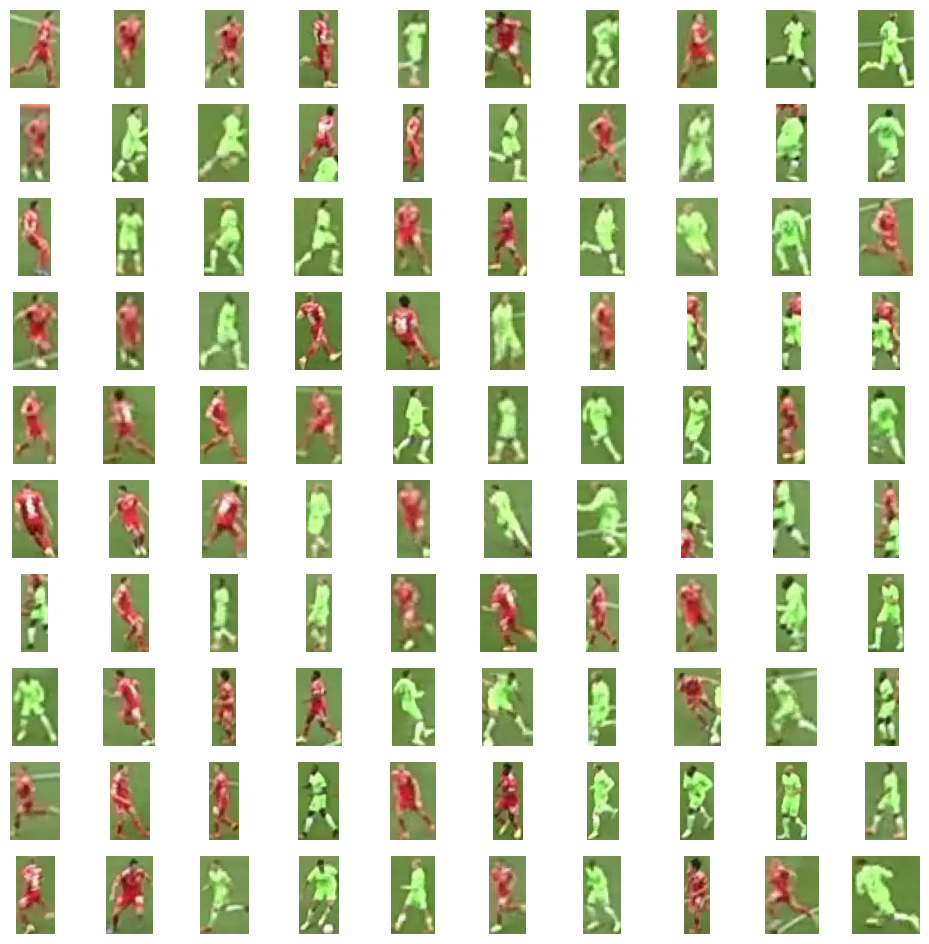

In [6]:
sv.plot_images_grid(crops[:100],grid_size=(10,10))

## SigLip Model to get embeddings

In [7]:
import torch
from transformers import AutoProcessor, SiglipVisionModel


SIGLIP_MODEL_PATH='google/siglip-base-patch16-224'


DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDING_MODEL=SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDING_PROCESSOR=AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [8]:
from more_itertools import chunked 

BATCH_SIZE=32

crops=[sv.cv2_to_pillow(crop) for crop in crops]
batches=chunked(crops,BATCH_SIZE)
data=[]

with torch.no_grad():
    for batch in tqdm(batches,desc='embeddings_extraction'):
        inputs=EMBEDDING_PROCESSOR(images=batch,return_tensors='pt').to(DEVICE)
        outputs=EMBEDDING_MODEL(**(inputs))
        embeddings=torch.mean(outputs.last_hidden_state,dim=1).cpu().numpy()
        data.append(embeddings)


embeddings_extraction: 0it [00:00, ?it/s]

In [9]:
data=np.concatenate(data)
print(data.shape)

(498, 768)


## UMAP for dimensionality reduction and Kmeans for clustering

In [10]:
import umap
from sklearn.cluster import KMeans

REDUCER=umap.UMAP(n_components=3)
CLUSTERING_MODEL=KMeans(n_clusters=2)

In [11]:
projections=REDUCER.fit_transform(data)

In [12]:
projections.shape

(498, 3)

In [13]:
clusters=CLUSTERING_MODEL.fit_predict(projections)

In [14]:
clusters[:10]

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 0], dtype=int32)

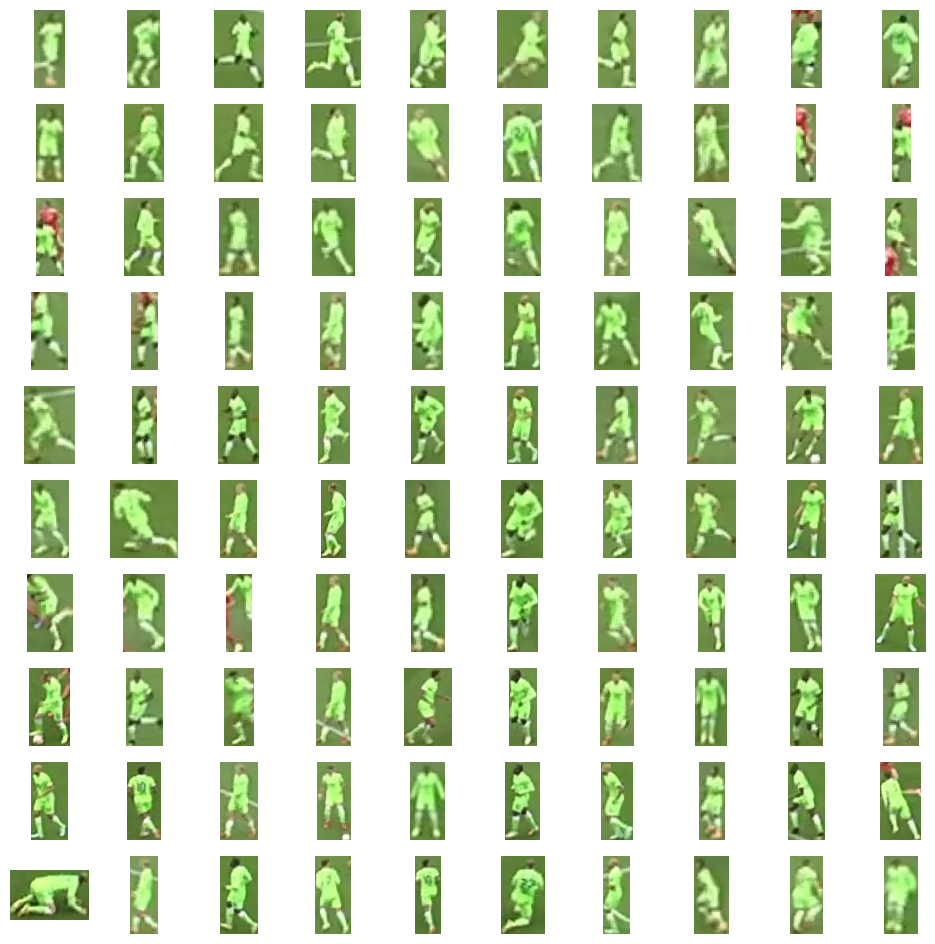

In [18]:
team_0=[crop for crop,cluster in zip(crops,clusters) if cluster == 0]

sv.plot_images_grid(team_0[:100],grid_size=[10,10])

# Applying the above method to sample image

In [56]:
def resolve_goalkeepers_team_id(players_detections: sv.Detections, goalkeepers_detections:sv.Detections):
    # using the assumption the midfielder and defense closer to the goalkeeper and thus on average goolkeeper will be closer to its overall mean value
    
    goalkeepers_xy=goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy=players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)


    team_0_centeroid = players_xy[players_detections.class_id==0].mean(axis=0)
    team_1_centeroid = players_xy[players_detections.class_id==1].mean(axis=0)



    goalkeepers_team_ids=[]
    for xy in goalkeepers_xy:
        dist_0=np.linalg.norm(xy-team_0_centeroid)
        dist_1=np.linalg.norm(xy-team_1_centeroid)

        goalkeepers_team_ids.append(0 if dist_0<dist_1 else 1)
        

    return np.array(goalkeepers_team_ids)
    
    

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 12.0ms
Speed: 10.0ms preprocess, 12.0ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 12.6ms
Speed: 10.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 13.7ms
Speed: 12.0ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 16.3ms
Speed: 9.9ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 12.1ms
Speed: 8.3ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 9.4ms
Speed: 7.6ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 9.9ms
Speed: 9.9ms preprocess, 9.9ms inference, 1.3ms postpr

Embedding extraction: 16it [00:02,  6.98it/s]



0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.6ms
Speed: 7.0ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00, 11.11it/s]


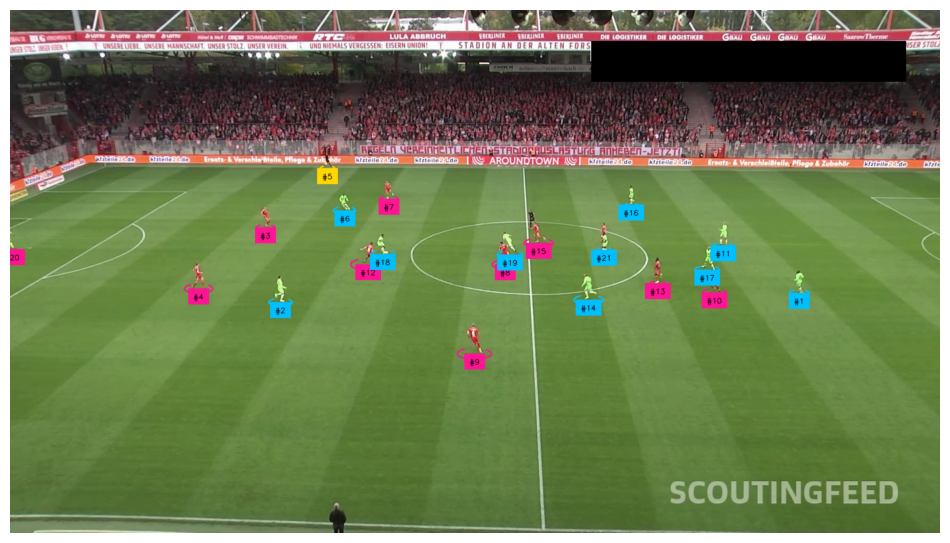

In [65]:
from utils.team import TeamClassifier

src_video_path='dataset/test/121364_0.mp4'
ball_id = 0
goalkeeper_id=1
player_id =  2
referee_id=3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

label_annotator=sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

crops=extract_crops(src_video_path)
team_classifier=TeamClassifier(device=DEVICE)
team_classifier.fit(crops)



tracker=sv.ByteTrack()
tracker.reset()

# getting the frame
frame_index = 66
frame_generator = sv.get_video_frames_generator(src_video_path)
frame = next(itertools.islice(frame_generator,frame_index,None))

# getting the detections
result = model(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)


ball_detections = detections[detections.class_id == ball_id]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

# detections except ball
all_detections = detections[detections.class_id != ball_id]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections=tracker.update_with_detections(all_detections)

# getting the players from detections
players_detections=all_detections[all_detections.class_id==player_id]
goalkeepers_detections=all_detections[all_detections.class_id==goalkeeper_id]
referees_detections=all_detections[all_detections.class_id==referee_id]

players_crops=[sv.crop_image(frame,xyxy) for xyxy in players_detections.xyxy] # cropping each player detections in image
players_detections.class_id=team_classifier.predict(players_crops)
goalkeepers_detections.class_id=resolve_goalkeepers_team_id(players_detections,goalkeepers_detections)

referees_detections.class_id-=1


all_detections=sv.Detections.merge([players_detections,goalkeepers_detections,referees_detections])



# how will be label be written 
labels = [
            f"#{tracker_id}"
            for tracker_id
            in all_detections.tracker_id
        ]

# using the desired method for annotation
annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(scene=annotated_frame,detections=all_detections)
annotated_frame = triangle_annotator.annotate(scene=annotated_frame,detections=ball_detections)
annotated_frame= label_annotator.annotate(scene=annotated_frame,detections=all_detections,labels=labels)


sv.plot_image(annotated_frame)

# Now for the entire video

In [67]:
from utils.team import TeamClassifier

src_video_path='dataset/test/121364_0.mp4'
target_video_path='dataset/test/121364_0_result_2.mp4'


ball_id = 0
goalkeeper_id=1
player_id =  2
referee_id=3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

label_annotator=sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER

)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
)

crops=extract_crops(src_video_path)
team_classifier=TeamClassifier(device=DEVICE)
team_classifier.fit(crops)



tracker=sv.ByteTrack()
tracker.reset()

# getting the frame
video_info=sv.VideoInfo.from_video_path(src_video_path)
video_sink=sv.VideoSink(target_video_path,video_info=video_info)
frame_generator=sv.get_video_frames_generator(src_video_path)

with video_sink:
    for i,frame in enumerate(tqdm(frame_generator,total=video_info.total_frames)):
        # getting the detections
        result = model(frame, conf=0.3)[0]
        detections = sv.Detections.from_ultralytics(result)
        
        
        ball_detections = detections[detections.class_id == ball_id]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
        
        # detections except ball
        all_detections = detections[detections.class_id != ball_id]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections=tracker.update_with_detections(all_detections)
        
        # getting the players from detections
        players_detections=all_detections[all_detections.class_id==player_id]
        goalkeepers_detections=all_detections[all_detections.class_id==goalkeeper_id]
        referees_detections=all_detections[all_detections.class_id==referee_id]
        
        players_crops=[sv.crop_image(frame,xyxy) for xyxy in players_detections.xyxy] # cropping each player detections in image
        players_detections.class_id=team_classifier.predict(players_crops)
        goalkeepers_detections.class_id=resolve_goalkeepers_team_id(players_detections,goalkeepers_detections)
        
        referees_detections.class_id-=1
        
        
        all_detections=sv.Detections.merge([players_detections,goalkeepers_detections,referees_detections])
        
        
        
        # how will be label be written 
        labels = [
                    f"#{tracker_id}"
                    for tracker_id
                    in all_detections.tracker_id
                ]

        print(all_detections.class_id)
        all_detections.class_id = all_detections.class_id.astype(int)
        print(all_detections.class_id)
        
        # using the desired method for annotation
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame,detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame,detections=ball_detections)
        annotated_frame= label_annotator.annotate(scene=annotated_frame,detections=all_detections,labels=labels)

        print(f"done for {i}th frame")
        
        # sv.plot_image(annotated_frame)
        video_sink.write_frame(annotated_frame)
        

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 14.2ms
Speed: 10.4ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.4ms
Speed: 8.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 11.4ms
Speed: 8.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 12.9ms
Speed: 12.5ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 22 players, 2 referees, 17.2ms
Speed: 12.7ms preprocess, 17.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 11.2ms
Speed: 14.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 17.1ms
Speed: 11.1ms preprocess, 17.1ms inference, 2.1ms 

Embedding extraction: 16it [00:02,  6.76it/s]


  0%|          | 0/750 [00:00<?, ?it/s]


0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.4ms
Speed: 7.6ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.00it/s]

[0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 2 2]
[0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 2 2]
done for 0th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.22it/s]


[0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 2 2]
[0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 2 2]
done for 1th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.40it/s]


[0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 2 2]
[0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 2 2]
done for 2th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.12it/s]


[1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 2]
[1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 2]
done for 3th frame

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 2 referees, 8.9ms
Speed: 6.2ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.24it/s]


[1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 2]
[1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 2]
done for 4th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.4ms
Speed: 6.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.90it/s]


[0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 2 2]
[0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 2 2]
done for 5th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.96it/s]

[1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 2 2]
[1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 2 2]
done for 6th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.31it/s]


[0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 2 2]
[0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 2 2]
done for 7th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.3ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.96it/s]


[0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 2]
[0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 2]
done for 8th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 2]
[1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 2]
done for 9th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.8ms
Speed: 6.2ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.67it/s]


[0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 2 2]
[0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 2 2]
done for 10th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.51it/s]


[0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 2 2]
[0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 2 2]
done for 11th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.3ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.06it/s]


[0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 2]
[0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 2]
done for 12th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.03it/s]


[0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 2 2]
[0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 2 2]
done for 13th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.75it/s]


[1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 2 2]
[1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 2 2]
done for 14th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.5ms
Speed: 6.4ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.19it/s]


[0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 2 2]
[0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 2 2]
done for 15th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.09it/s]


[1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 2 2]
[1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 2 2]
done for 16th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 11.3ms
Speed: 8.1ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.55it/s]

[0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 2 2]
[0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 2 2]
done for 17th frame



0: 736x1280 1 goalkeeper, 22 players, 1 referee, 8.6ms
Speed: 6.7ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.56it/s]

[0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 2]
[0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 2]
done for 18th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.5ms
Speed: 6.4ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.11it/s]


[0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 2 2]
[0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 2 2]
done for 19th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 8.5ms
Speed: 6.3ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.21it/s]


[0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 2 2]
[0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 2 2]
done for 20th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 11.5ms
Speed: 6.7ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.61it/s]

[0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 2 2]
[0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 2 2]
done for 21th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 8.5ms
Speed: 6.3ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.23it/s]


[0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 2 2]
[0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 2 2]
done for 22th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.8ms
Speed: 6.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.08it/s]


[0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 2 2]
[0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 2 2]
done for 23th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.32it/s]

[0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 2 2]
[0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 2 2]
done for 24th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 10.1ms
Speed: 8.0ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.49it/s]

[0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 2 2]
[0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 2 2]
done for 25th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.9ms
Speed: 7.4ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.09it/s]

[0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 2 2]
[0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 2 2]
done for 26th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 38.2ms
Speed: 7.1ms preprocess, 38.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.38it/s]

[0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 2 2]
[0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 2 2]


done for 27th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 11.5ms
Speed: 9.1ms preprocess, 11.5ms inference, 8.0ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.66it/s]

[1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 2 2]
[1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 2 2]
done for 28th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 12.7ms
Speed: 6.9ms preprocess, 12.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.59it/s]

[0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 2 2]
[0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 2 2]
done for 29th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.6ms
Speed: 6.6ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.03it/s]

[1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 2 2]
[1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 2 2]
done for 30th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 12.6ms
Speed: 8.0ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.70it/s]

[1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 2 2]
[1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 2 2]
done for 31th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.4ms
Speed: 8.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.93it/s]

[1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 2 2]
[1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 2 2]
done for 32th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.2ms
Speed: 32.9ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.04it/s]

[1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 2 2]
[1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 2 2]
done for 33th frame



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 11.9ms
Speed: 8.3ms preprocess, 11.9ms inference, 6.1ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.17it/s]

[0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 2 2]
[0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 2 2]
done for 34th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.8ms
Speed: 6.5ms preprocess, 10.8ms inference, 6.7ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.48it/s]

[0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 2 2]
[0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 2 2]
done for 35th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 10.2ms
Speed: 10.5ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.88it/s]

[0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 2 2]
[0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 2 2]
done for 36th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.0ms
Speed: 6.6ms preprocess, 10.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.32it/s]

[0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 2 2]
[0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 2 2]
done for 37th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 7.0ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.57it/s]

[0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 2 2]
[0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 2 2]
done for 38th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.5ms
Speed: 6.4ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.29it/s]


[1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 2 2]
[1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 2 2]
done for 39th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.10it/s]

[1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 2 2]
[1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 2 2]
done for 40th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 7.2ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.26it/s]

[1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 2 2]
[1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 2 2]
done for 41th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms


Speed: 6.7ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.41it/s]

[1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 2 2]
[1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 2 2]
done for 42th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.87it/s]

[1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 2 2]
[1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 2 2]
done for 43th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 12.3ms
Speed: 6.9ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.63it/s]

[0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 2 2]
[0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 2 2]
done for 44th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 10.2ms
Speed: 7.2ms preprocess, 10.2ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.10it/s]

[0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 2 2]
[0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 2 2]
done for 45th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 10.4ms
Speed: 6.9ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.71it/s]

[1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 2 2]
[1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 2 2]
done for 46th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.3ms
Speed: 6.9ms preprocess, 10.3ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.24it/s]

[0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 2 2]
[0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 2 2]
done for 47th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 14.3ms
Speed: 11.0ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.39it/s]

[0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 2 2]
[0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 2 2]
done for 48th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.10it/s]


[0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 2 2]
[0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 2 2]
done for 49th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 9.5ms
Speed: 7.1ms preprocess, 9.5ms inference, 6.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.78it/s]

[0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 2 2]
[0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 2 2]
done for 50th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 7.2ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.41it/s]

[1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 2 2]
[1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 2 2]
done for 51th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.9ms
Speed: 7.5ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.71it/s]

[0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 2 2]
[0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 2 2]
done for 52th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.6ms
Speed: 7.1ms preprocess, 9.6ms inference, 7.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.56it/s]

[0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 2 2]
[0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 2 2]
done for 53th frame



0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 10.3ms
Speed: 6.8ms preprocess, 10.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.25it/s]

[1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 2 2]
[1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 2 2]
done for 54th frame



0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.03it/s]

[1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 2 2]
[1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 2 2]
done for 55th frame



0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 9.2ms
Speed: 7.0ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.12it/s]


[1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 2 2]
[1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 2 2]
done for 56th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 9.8ms
Speed: 7.2ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.43it/s]

[0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0 2 2]
[0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0 2 2]
done for 57th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.6ms
Speed: 7.0ms preprocess, 10.6ms inference, 8.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.59it/s]

[0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 2 2]
[0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 2 2]
done for 58th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.5ms
Speed: 7.0ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.82it/s]

[0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 2 2]
[0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 2 2]
done for 59th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.01it/s]


[0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 2 2]
[0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 2 2]
done for 60th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.7ms
Speed: 7.2ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.00it/s]

[0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 2 2]
[0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 2 2]
done for 61th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 39.0ms
Speed: 6.7ms preprocess, 39.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.42it/s]

[1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 2]
[1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 2]
done for 62th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.4ms
Speed: 7.3ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.90it/s]

[1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 2 2]
[1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 2 2]
done for 63th frame



0: 736x1280 1 goalkeeper, 19 players, 1 referee, 8.8ms
Speed: 8.1ms preprocess, 8.8ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.97it/s]

[0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 2]
[0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 2]
done for 64th frame



0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.7ms
Speed: 6.6ms preprocess, 9.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.27it/s]

[1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 2]
[1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 2]


done for 65th frame

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 13.1ms
Speed: 9.4ms preprocess, 13.1ms inference, 6.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.06it/s]

[          1           1           0           0           1           0           0           0           0           1           0           0           1           0           1           1           1           1           1           2]
[1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 2]
done for 66th frame



0: 736x1280 21 players, 1 referee, 9.6ms
Speed: 6.5ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.62it/s]

[          0           0           1           0           1           0           0           1           0           0           1           1           1           1           0           1           1           0           1           0           2]
[0 0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 2]
done for 67th frame



0: 736x1280 22 players, 1 referee, 13.2ms
Speed: 6.5ms preprocess, 13.2ms inference, 6.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.64it/s]

[          0           0           0           1           1           0           1           0           1           1           1           0           0           1           0           1           1           0           1           2]
[0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 2]
done for 68th frame



0: 736x1280 21 players, 1 referee, 10.3ms
Speed: 6.6ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.38it/s]

[          0           0           1           0           0           1           0           0           1           1           1           1           0           1           1           0           0           1           1           2]
[0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 2]
done for 69th frame



0: 736x1280 20 players, 1 referee, 10.6ms
Speed: 10.8ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.02it/s]

[          0           1           0           1           1           1           1           0           1           0           0           0           1           0           0           0           1           0           1           2]
[0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 2]
done for 70th frame

0: 736x1280 24 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.00it/s]


[          0           1           0           0           0           0           0           0           1           1           1           0           1           0           1           1           1           0           1           2           2]
[0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 2 2]
done for 71th frame

0: 736x1280 22 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.51it/s]


[          1           1           0           1           1           0           0           0           0           1           0           1           1           0           0           0           1           0           1           2           2]
[1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 2 2]
done for 72th frame

0: 736x1280 24 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.63it/s]

[          1           1           1           1           0           1           0           0           0           0           0           0           1           1           0           1           0           1           1           2           2]
[1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 2 2]
done for 73th frame



0: 736x1280 21 players, 2 referees, 10.3ms
Speed: 7.1ms preprocess, 10.3ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.60it/s]

[          0           1           0           0           1           1           0           0           1           1           0           0           0           1           1           0           1           0           1           2           2]
[0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 2 2]
done for 74th frame



0: 736x1280 21 players, 2 referees, 10.2ms
Speed: 6.8ms preprocess, 10.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.03it/s]


[          0           1           1           0           0           1           0           1           0           0           0           1           0           1           0           1           1           1           1           2           2]
[0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 2 2]
done for 75th frame

0: 736x1280 21 players, 2 referees, 9.2ms
Speed: 6.9ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.33it/s]


[          0           1           1           0           1           0           0           0           1           0           1           1           0           1           0           0           1           1           1           2           2]
[0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 2 2]
done for 76th frame

0: 736x1280 23 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.82it/s]


[          0           0           1           1           1           1           0           0           0           1           0           1           0           0           1           1           1           0           0           1           2           2]
[0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 2 2]
done for 77th frame

0: 736x1280 22 players, 2 referees, 9.0ms
Speed: 6.8ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.87it/s]


[          0           0           1           1           1           1           0           0           0           0           1           1           1           0           1           0           1           0           1           0           2           2]
[0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 2 2]
done for 78th frame

0: 736x1280 22 players, 2 referees, 8.5ms
Speed: 6.5ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.94it/s]


[          0           0           1           1           0           1           1           0           1           0           0           0           1           0           1           1           1           0           0           1           2           2]
[0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 2 2]
done for 79th frame

0: 736x1280 20 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.18it/s]


[          0           0           0           1           1           1           1           0           0           1           0           1           0           1           0           0           1           1           1           0           2           2]
[0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 2 2]
done for 80th frame

0: 736x1280 23 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.05it/s]

[          0           1           0           0           0           1           0           1           1           1           0           1           1           1           0           0           1           1           0           0           2           2]
[0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 2 2]
done for 81th frame



0: 736x1280 21 players, 2 referees, 12.5ms
Speed: 6.5ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.77it/s]

[          1           0           0           0           0           0           1           1           0           1           1           1           1           1           1           0           0           1           0           1           2           2]
[1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 2 2]
done for 82th frame

0: 736x1280 21 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.14it/s]


[          0           0           1           1           0           0           1           0           0           1           1           1           0           1           1           1           1           0           0           0           2           2]
[0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 2 2]
done for 83th frame

0: 736x1280 21 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.04it/s]


[          0           0           0           0           1           0           1           0           1           1           1           1           0           1           1           1           1           0           0           0           2           2]
[0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 2 2]
done for 84th frame

0: 736x1280 21 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.06it/s]


[          0           0           0           1           0           1           0           0           1           1           1           0           1           0           0           1           1           1           0           1           2           2]
[0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 1 2 2]
done for 85th frame

0: 736x1280 21 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.50it/s]


[          0           1           1           0           0           0           0           1           0           1           0           0           1           1           1           0           1           1           0           1           0           2           2]
[0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 2 2]
done for 86th frame

0: 736x1280 22 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.14it/s]


[          0           1           0           1           1           0           0           1           0           0           1           1           0           0           1           0           1           0           1           1           2           2]
[0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 2 2]
done for 87th frame

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.55it/s]


[          1           1           0           1           1           1           0           0           0           0           0           1           0           1           0           0           0           1           1           1           0           2           2]
[1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 2 2]
done for 88th frame

0: 736x1280 22 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.11it/s]


[          0           1           0           1           0           1           0           0           1           1           0           1           0           0           0           1           1           0           1           1           2           2]
[0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 2 2]
done for 89th frame

0: 736x1280 20 players, 2 referees, 8.5ms
Speed: 6.5ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.02it/s]


[          0           1           1           0           0           0           0           1           1           1           0           0           0           1           1           1           0           1           1           0           2           2]
[0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 2 2]
done for 90th frame

0: 736x1280 21 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.16it/s]


[          0           0           1           0           0           0           1           1           1           1           0           1           0           1           1           1           0           0           1           0           2           2]
[0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 2 2]
done for 91th frame

0: 736x1280 21 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.91it/s]


[          0           0           1           1           0           1           0           0           1           0           0           0           1           1           1           1           1           1           0           0           2           2]
[0 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 2 2]
done for 92th frame

0: 736x1280 22 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.02it/s]


[          1           0           1           0           0           0           0           1           0           1           0           1           1           1           0           1           0           1           1           0           2           2]
[1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 2 2]
done for 93th frame

0: 736x1280 20 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.11it/s]


[          0           0           1           1           0           1           0           1           0           1           0           1           1           0           0           1           1           1           0           0           2           2]
[0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 2 2]
done for 94th frame

0: 736x1280 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.08it/s]


[          1           0           1           0           1           0           0           0           0           1           1           1           1           1           0           0           0           1           0           1           2           2]
[1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 2 2]
done for 95th frame

0: 736x1280 21 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.02it/s]


[          1           0           0           0           0           1           1           1           0           1           1           1           1           0           0           1           0           0           1           0           2           2]
[1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 2 2]
done for 96th frame

0: 736x1280 21 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.38it/s]


[          1           0           0           1           1           0           1           1           0           0           1           1           0           1           1           0           1           0           0           0           0           2           2]
[1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 2 2]
done for 97th frame

0: 736x1280 20 players, 2 referees, 8.5ms
Speed: 6.4ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.04it/s]


[          1           0           0           1           0           0           1           1           0           1           1           0           0           1           1           0           1           0           1           0           2           2]
[1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 2 2]
done for 98th frame

0: 736x1280 20 players, 3 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.13it/s]


[          0           0           1           1           0           1           0           1           1           0           0           0           0           1           1           1           1           0           1           0           2           2]
[0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 2 2]
done for 99th frame

0: 736x1280 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.90it/s]


[          0           0           1           1           0           0           1           0           1           0           1           0           0           1           0           1           1           1           0           1           2           2]
[0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 2 2]
done for 100th frame

0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.98it/s]


[          1           0           1           1           0           0           0           1           1           1           0           0           1           1           0           0           1           0           1           0           2           2]
[1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 2 2]
done for 101th frame

0: 736x1280 21 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.11it/s]


[          0           0           1           1           1           1           0           0           1           1           0           0           0           1           0           1           0           1           0           1           2           2]
[0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 2 2]
done for 102th frame

0: 736x1280 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[          1           1           0           1           1           1           0           1           0           0           0           0           1           0           0           1           0           1           0           1           2           2]
[1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 2 2]
done for 103th frame

0: 736x1280 20 players, 2 referees, 10.2ms
Speed: 6.6ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[          1           1           0           1           1           0           1           0           1           1           0           1           0           0           0           0           1           0           0           1           2           2]
[1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 2 2]
done for 104th frame

0: 736x1280 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.20it/s]


[          0           0           1           1           1           1           1           0           0           0           0           1           0           1           1           1           0           0           1           0           2           2]
[0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 2 2]
done for 105th frame

0: 736x1280 21 players, 2 referees, 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[          1           0           0           1           1           0           1           1           1           1           0           0           0           1           0           0           0           1           1           0           2           2]
[1 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 2 2]
done for 106th frame

0: 736x1280 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.09it/s]


[          1           0           1           1           0           1           0           1           1           1           1           0           0           0           0           0           0           1           0           1           2           2]
[1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 2 2]
done for 107th frame

0: 736x1280 20 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.16it/s]


[          1           1           0           1           0           0           1           1           0           1           0           1           0           0           1           0           0           0           1           1           2           2]
[1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 2 2]
done for 108th frame

0: 736x1280 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.04it/s]


[          0           0           1           0           1           1           1           1           1           0           0           1           1           0           0           0           0           1           0           1           2           2]
[0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 2 2]
done for 109th frame

0: 736x1280 20 players, 2 referees, 8.5ms
Speed: 6.5ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.87it/s]


[          1           1           1           0           1           0           0           1           1           1           0           0           0           0           0           0           0           1           1           1           2           2]
[1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 2 2]
done for 110th frame

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.41it/s]


[          1           1           1           0           0           0           0           1           0           0           1           0           1           0           0           1           1           0           1           1           2           2]
[1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 2 2]
done for 111th frame

0: 736x1280 20 players, 2 referees, 8.8ms
Speed: 6.3ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.79it/s]


[          0           0           1           1           1           0           1           0           1           1           1           1           0           0           0           0           0           0           1           1           2           2]
[0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 2 2]
done for 112th frame

0: 736x1280 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.79it/s]


[          0           0           1           1           1           0           1           0           1           1           1           1           0           0           0           0           0           0           1           1           2           2]
[0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 2 2]
done for 113th frame

0: 736x1280 23 players, 2 referees, 8.8ms
Speed: 6.7ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.83it/s]


[          1           0           0           1           0           1           0           1           1           1           0           1           0           1           0           0           0           0           1           1           2           2]
[1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 2 2]
done for 114th frame

0: 736x1280 20 players, 3 referees, 8.5ms
Speed: 6.5ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.95it/s]


[          0           0           1           1           0           0           1           0           0           0           1           1           0           0           1           0           1           1           1           1           2           2]
[0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 2 2]
done for 115th frame

0: 736x1280 20 players, 3 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[          0           1           0           0           1           0           1           0           0           0           1           1           1           0           0           1           0           1           1           1           2           2]
[0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 2 2]
done for 116th frame

0: 736x1280 21 players, 4 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.06it/s]


[          1           0           0           1           0           1           1           1           1           0           0           0           1           0           0           1           0           0           1           1           2           2]
[1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 2 2]
done for 117th frame

0: 736x1280 20 players, 3 referees, 10.0ms
Speed: 6.6ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.07it/s]


[          1           1           0           0           1           0           1           0           1           0           0           1           0           1           0           1           0           1           0           1           2           2]
[1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 2 2]
done for 118th frame

0: 736x1280 21 players, 2 referees, 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.92it/s]


[          1           1           1           0           0           1           0           1           0           1           0           1           1           0           0           0           0           1           1           0           2           2]
[1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 2 2]
done for 119th frame

0: 736x1280 22 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[          0           0           1           0           0           1           1           1           1           0           0           1           1           1           0           1           0           0           1           0           2           2]
[0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 2 2]
done for 120th frame

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.06it/s]


[          0           1           1           1           0           0           1           1           1           0           0           1           1           1           0           0           0           0           1           0           2           2]
[0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 2 2]
done for 121th frame

0: 736x1280 24 players, 2 referees, 8.7ms
Speed: 6.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.00it/s]


[          0           1           1           1           1           1           0           0           0           1           1           1           1           1           0           0           0           0           0           0           2           2]
[0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 2 2]
done for 122th frame

0: 736x1280 21 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.08it/s]


[          1           1           1           0           1           1           1           0           0           1           1           0           1           0           0           0           0           0           0           1           2           2]
[1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 2 2]
done for 123th frame

0: 736x1280 20 players, 2 referees, 9.8ms
Speed: 6.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.04it/s]


[          1           1           0           1           1           1           0           1           0           0           1           1           0           0           1           0           0           0           1           0           2           2]
[1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 2 2]
done for 124th frame

0: 736x1280 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.03it/s]


[          1           1           1           0           0           1           1           1           0           0           0           1           0           1           0           0           0           1           1           0           2           2]
[1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 0 2 2]
done for 125th frame

0: 736x1280 21 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.95it/s]


[          1           1           1           0           1           1           0           0           0           0           0           1           0           0           1           1           0           1           1           0           2           2]
[1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 2 2]
done for 126th frame

0: 736x1280 20 players, 2 referees, 8.6ms
Speed: 6.7ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[          0           1           1           1           0           1           0           0           0           1           1           0           0           1           1           1           0           0           0           1           2           2]
[0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 2 2]
done for 127th frame

0: 736x1280 20 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.46it/s]

[          1           0           0           0           1           1           1           0           1           1           1           0           0           0           1           0           0           1           0           1           2           2]
[1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 2 2]
done for 128th frame



0: 736x1280 20 players, 2 referees, 11.3ms
Speed: 8.1ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.63it/s]

[          1           1           1           0           1           0           0           0           0           0           0           1           1           0           0           1           1           1           0           1           2           2]
[1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 2 2]
done for 129th frame

0: 736x1280 22 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.98it/s]


[          0           0           0           1           1           1           1           0           0           1           0           1           1           0           0           1           0           0           1           1           2           2]
[0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 2 2]
done for 130th frame

0: 736x1280 20 players, 2 referees, 9.1ms
Speed: 6.8ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.58it/s]

[          1           0           1           0           1           1           0           1           0           1           0           0           1           0           0           1           0           1           0           1           2           2]
[1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 2 2]
done for 131th frame

0: 736x1280 20 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.15it/s]

[          1           1           1           1           1           1           1           1           0           0           0           0           1           0           0           0           0           0           0           1           2           2]
[1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 2 2]
done for 132th frame

0: 736x1280 1 ball, 21 players, 2 referees, 9.4ms
Speed: 6.4ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.35it/s]

[          1           0           1           1           1           0           1           1           0           0           0           0           1           0           0           1           1           0           0           1           2           2]
[1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 2 2]
done for 133th frame



0: 736x1280 1 ball, 24 players, 2 referees, 8.9ms
Speed: 8.7ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.63it/s]

[          0           0           1           1           0           1           1           0           1           0           1           0           0           1           1           0           0           0           0           1           2           2]
[0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 2 2]
done for 134th frame



0: 736x1280 2 balls, 21 players, 2 referees, 9.2ms
Speed: 8.4ms preprocess, 9.2ms inference, 9.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.31it/s]

[          1           1           0           0           1           1           0           1           0           0           1           0           1           0           1           0           0           1           0           2           2]
[1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 2 2]
done for 135th frame

0: 736x1280 1 ball, 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.46it/s]


[          0           1           0           0           0           1           1           1           1           0           0           1           1           1           0           1           0           0           0           2           2]
[0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 2 2]
done for 136th frame

0: 736x1280 1 ball, 20 players, 1 referee, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  6.96it/s]


[          1           0           1           1           0           1           0           0           1           0           1           0           0           1           1           1           0           0           0           2]
[1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 2]
done for 137th frame

0: 736x1280 1 ball, 24 players, 1 referee, 8.8ms
Speed: 8.2ms preprocess, 8.8ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.06it/s]

[          1           0           0           1           1           0           0           1           1           0           1           1           1           1           0           0           0           0           0           2]
[1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 2]
done for 138th frame



0: 736x1280 1 ball, 21 players, 2 referees, 9.6ms
Speed: 7.1ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.95it/s]

[          0           0           1           1           1           0           1           0           0           1           1           1           1           1           0           0           0           0           0           2           2]
[0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 2 2]
done for 139th frame



0: 736x1280 22 players, 2 referees, 10.9ms
Speed: 6.8ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.98it/s]


[          0           0           0           1           1           1           1           1           0           1           1           0           1           0           0           1           0           0           0           2           2]
[0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 2 2]
done for 140th frame

0: 736x1280 1 ball, 20 players, 2 referees, 11.6ms
Speed: 8.1ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.73it/s]

[          0           0           0           1           1           0           1           1           0           1           1           0           1           0           1           0           0           1           1           2           2]
[0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 2 2]
done for 141th frame



0: 736x1280 1 ball, 22 players, 1 referee, 10.1ms
Speed: 6.8ms preprocess, 10.1ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.85it/s]

[          1           0           0           0           1           1           1           1           0           0           0           1           1           1           0           1           0           1           0           2]
[1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 2]
done for 142th frame



0: 736x1280 1 ball, 22 players, 1 referee, 12.4ms
Speed: 9.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.46it/s]

[          1           0           0           1           1           1           1           0           1           0           0           0           0           1           0           1           1           1           0           0           2]
[1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 2]
done for 143th frame



0: 736x1280 1 ball, 20 players, 1 referee, 10.6ms
Speed: 10.9ms preprocess, 10.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.11it/s]


[          0           1           0           1           0           1           1           1           0           0           0           1           1           0           0           1           1           1           0           0           2]
[0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 0 2]
done for 144th frame

0: 736x1280 1 ball, 23 players, 1 referee, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.84it/s]

[          1           0           1           0           1           1           0           0           0           1           1           0           0           1           0           1           0           1           0           1           2]
[1 0 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 2]
done for 145th frame



0: 736x1280 1 ball, 23 players, 1 referee, 10.5ms
Speed: 6.5ms preprocess, 10.5ms inference, 9.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.08it/s]


[          1           0           0           1           0           0           1           1           1           0           0           1           1           0           1           0           0           1           0           1           2]
[1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 2]
done for 146th frame

0: 736x1280 1 ball, 22 players, 1 referee, 10.5ms
Speed: 6.9ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.39it/s]

[          0           1           1           0           1           1           0           0           0           1           1           0           0           0           1           1           0           1           0           1           1           2]
[0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 2]
done for 147th frame



0: 736x1280 1 ball, 23 players, 1 referee, 10.0ms
Speed: 6.4ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.47it/s]

[          0           1           0           1           1           1           1           0           1           0           0           1           1           0           0           0           0           1           0           1           1           2]
[0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 2]
done for 148th frame

0: 736x1280 1 ball, 23 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.50it/s]

[          0           1           1           0           1           1           0           0           1           0           0           0           1           1           0           0           0           1           1           1           2]
[0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 2]
done for 149th frame



0: 736x1280 1 ball, 21 players, 2 referees, 9.1ms
Speed: 6.9ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.16it/s]

[          0           0           1           1           1           1           0           1           1           0           0           0           0           1           1           0           0           0           1           1           1           2           2]
[0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 2 2]
done for 150th frame



0: 736x1280 1 ball, 21 players, 2 referees, 9.0ms
Speed: 6.8ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.00it/s]

[          0           1           1           0           1           1           0           0           0           1           0           0           1           1           0           1           0           1           0           1           1           2           2]
[0 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 2 2]
done for 151th frame



0: 736x1280 1 ball, 23 players, 2 referees, 11.2ms
Speed: 8.0ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.11it/s]

[          0           1           1           0           0           1           1           0           0           0           1           1           1           0           1           0           0           0           1           1           1           2           2]
[0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 2 2]
done for 152th frame



0: 736x1280 2 balls, 22 players, 2 referees, 10.0ms
Speed: 6.6ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.80it/s]


[          0           0           1           0           0           1           1           0           1           1           1           0           0           1           1           0           0           0           1           1           2           2]
[0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 2 2]
done for 153th frame

0: 736x1280 1 ball, 21 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.21it/s]


[          1           0           0           1           0           1           1           1           0           1           0           0           0           1           0           1           0           0           1           2           2]
[1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 2 2]
done for 154th frame

0: 736x1280 1 ball, 21 players, 2 referees, 9.1ms
Speed: 6.3ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.25it/s]


[          1           0           1           0           1           1           0           0           1           0           1           1           0           0           1           0           0           0           1           2           2]
[1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 2 2]
done for 155th frame

0: 736x1280 22 players, 3 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.42it/s]


[          0           1           0           1           1           1           1           0           1           0           0           0           0           1           1           0           0           1           0           2           2]
[0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 2 2]
done for 156th frame

0: 736x1280 21 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.11it/s]


[          0           1           0           1           1           1           0           0           0           0           0           1           1           1           0           1           0           1           1           0           2           2]
[0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 2 2]
done for 157th frame

0: 736x1280 20 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[          1           0           0           0           0           0           1           1           0           1           0           1           1           0           0           1           1           1           1           1           2           2]
[1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 2 2]
done for 158th frame

0: 736x1280 1 ball, 20 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.98it/s]


[          1           1           0           0           0           0           0           1           1           0           0           1           1           0           1           0           1           1           0           0           2           2]
[1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 2 2]
done for 159th frame

0: 736x1280 21 players, 3 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.02it/s]


[          1           1           0           1           0           0           1           1           0           0           0           1           0           1           0           1           0           1           0           0           2           2]
[1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 2 2]
done for 160th frame

0: 736x1280 1 ball, 21 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[          1           1           1           0           0           1           1           1           0           0           0           0           1           0           0           1           0           1           1           0           2           2]
[1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 2 2]
done for 161th frame

0: 736x1280 1 ball, 21 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.63it/s]

[          1           1           1           1           1           0           0           0           0           1           0           0           0           1           0           1           1           0           1           1           2           2]
[1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 2 2]
done for 162th frame



0: 736x1280 1 ball, 21 players, 2 referees, 9.3ms
Speed: 6.9ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[          1           1           1           0           1           1           0           0           0           0           0           0           1           1           1           0           0           1           1           1           2           2]
[1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 2 2]
done for 163th frame

0: 736x1280 2 balls, 21 players, 2 referees, 8.5ms
Speed: 6.4ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.39it/s]


[          1           1           0           0           0           1           1           1           0           1           1           1           0           0           0           1           0           0           2           2]
[1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 2 2]
done for 164th frame

0: 736x1280 2 balls, 21 players, 2 referees, 9.2ms
Speed: 10.3ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.51it/s]


[          0           1           1           0           1           0           1           1           1           0           0           1           0           0           1           0           1           0           0           2           2]
[0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 2 2]
done for 165th frame

0: 736x1280 2 balls, 20 players, 3 referees, 8.6ms
Speed: 9.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.42it/s]


[          0           1           0           1           1           1           1           1           0           0           1           0           0           1           0           1           0           0           0           2           2]
[0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 2 2]
done for 166th frame

0: 736x1280 1 ball, 20 players, 3 referees, 8.5ms
Speed: 9.9ms preprocess, 8.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.85it/s]


[          1           0           0           1           1           1           0           0           1           0           1           1           0           0           0           1           1           0           1           0           2           2]
[1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 2 2]
done for 167th frame

0: 736x1280 1 ball, 21 players, 3 referees, 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.04it/s]


[          0           0           1           0           1           1           1           0           1           1           0           1           1           1           0           0           0           0           0           1           2           2]
[0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 2 2]
done for 168th frame

0: 736x1280 1 ball, 21 players, 2 referees, 10.0ms
Speed: 6.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.41it/s]


[          0           1           1           1           1           0           0           1           1           0           0           0           1           0           1           0           0           1           0           2           2]
[0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 2 2]
done for 169th frame

0: 736x1280 1 ball, 21 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.23it/s]


[          1           1           0           0           1           0           0           1           0           0           0           0           1           0           1           1           1           1           0           2           2]
[1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 2 2]
done for 170th frame

0: 736x1280 19 players, 2 referees, 8.6ms
Speed: 6.3ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.45it/s]


[          1           0           1           1           1           0           0           0           0           0           1           0           1           1           1           0           1           0           0           2           2]
[1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 2 2]
done for 171th frame

0: 736x1280 1 ball, 20 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.49it/s]


[          1           1           0           1           1           0           0           0           1           0           1           0           1           0           1           0           0           1           0           2           2]
[1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 2 2]
done for 172th frame

0: 736x1280 21 players, 2 referees, 11.3ms
Speed: 8.1ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.00it/s]

[          1           0           1           1           0           0           1           0           0           0           0           1           0           0           1           1           1           1           2           2]
[1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 2 2]
done for 173th frame



0: 736x1280 21 players, 2 referees, 11.3ms
Speed: 12.7ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.33it/s]

[          0           1           0           0           1           1           0           0           0           0           1           0           1           0           1           1           1           1           0           2           2]
[0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 2 2]
done for 174th frame

0: 736x1280 20 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.29it/s]


[          1           1           1           0           0           0           0           0           1           1           0           1           0           1           0           1           1           0           0           2           2]
[1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 2 2]
done for 175th frame

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.28it/s]


[          0           0           1           1           1           1           1           1           1           0           0           0           1           0           0           0           1           0           0           2           2]
[0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 2 2]
done for 176th frame

0: 736x1280 20 players, 2 referees, 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.48it/s]


[          0           0           1           1           1           0           1           1           1           1           0           1           0           0           0           0           0           1           0           2           2]
[0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 2 2]
done for 177th frame

0: 736x1280 21 players, 2 referees, 11.3ms
Speed: 8.0ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.13it/s]

[          1           0           0           0           0           0           1           1           1           1           1           1           0           0           1           1           0           0           0           2           2]
[1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 2 2]
done for 178th frame

0: 736x1280 20 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.70it/s]


[          0           1           0           1           1           0           1           0           1           0           0           0           0           1           1           1           1           0           1           0           2           2]
[0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 2 2]
done for 179th frame

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.03it/s]


[          0           1           1           1           1           0           0           0           1           0           0           1           0           0           1           1           0           1           1           0           2           2]
[0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 2 2]
done for 180th frame

0: 736x1280 21 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.81it/s]


[          1           1           0           0           1           1           0           0           1           1           0           0           1           1           0           1           1           0           0           0           2           2]
[1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 2 2]
done for 181th frame

0: 736x1280 22 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.85it/s]


[          1           0           0           0           1           0           0           1           1           1           0           1           0           1           0           0           0           1           1           1           2           2]
[1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 2 2]
done for 182th frame

0: 736x1280 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.98it/s]


[          0           0           1           0           1           0           0           0           0           1           1           1           1           1           1           0           1           1           0           0           2           2]
[0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 2 2]
done for 183th frame

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.96it/s]


[          1           0           0           1           0           0           0           1           0           0           1           1           1           1           1           0           1           0           0           1           2           2]
[1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 2 2]
done for 184th frame

0: 736x1280 22 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.96it/s]


[          1           0           0           1           0           0           0           0           1           1           1           0           1           1           1           0           0           1           0           1           2           2]
[1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 2 2]
done for 185th frame

0: 736x1280 20 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.53it/s]


[          1           1           0           1           1           0           0           0           0           0           1           0           1           1           1           0           0           1           1           2           2]
[1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 2 2]
done for 186th frame

0: 736x1280 1 ball, 19 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.43it/s]


[          1           0           1           0           0           0           1           1           0           1           0           1           1           0           0           1           1           1           0           2           2]
[1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 2 2]
done for 187th frame

0: 736x1280 1 ball, 19 players, 3 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.35it/s]


[          0           0           1           0           0           1           0           0           1           1           0           1           1           1           1           0           1           1           0           2           2]
[0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 2 2]
done for 188th frame

0: 736x1280 1 ball, 20 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.50it/s]


[          0           0           1           1           0           0           0           0           1           1           0           1           1           1           1           1           0           1           0           2           2]
[0 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 2 2]
done for 189th frame

0: 736x1280 1 ball, 22 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.40it/s]


[          0           0           1           1           0           0           0           1           0           1           0           1           1           1           0           1           0           1           1           2           2]
[0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 1 2 2]
done for 190th frame

0: 736x1280 23 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.34it/s]


[          0           1           1           0           0           0           1           1           1           0           0           0           1           0           1           1           1           0           0           2           2]
[0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 2 2]
done for 191th frame

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.36it/s]


[          0           0           1           0           0           0           1           0           1           0           1           1           0           1           1           0           1           1           0           2           2]
[0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 2 2]
done for 192th frame

0: 736x1280 21 players, 2 referees, 11.9ms
Speed: 7.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.30it/s]

[          1           0           0           0           0           0           1           1           1           0           0           1           1           0           1           0           1           1           0           0           2           2]
[1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 2 2]
done for 193th frame



0: 736x1280 1 ball, 19 players, 2 referees, 9.6ms
Speed: 6.6ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.20it/s]

[          1           0           0           0           1           1           1           1           1           0           0           0           0           1           0           1           0           1           0           2           2]
[1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 2 2]
done for 194th frame

0: 736x1280 1 ball, 19 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.20it/s]


[          1           0           1           1           0           1           0           0           1           0           1           1           0           1           0           0           1           0           0           2           2]
[1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 2 2]
done for 195th frame

0: 736x1280 1 ball, 19 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.36it/s]


[          0           1           1           1           0           1           0           1           0           0           1           0           1           1           0           0           1           0           0           2           2]
[0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 2 2]
done for 196th frame

0: 736x1280 1 ball, 20 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.39it/s]


[          0           0           1           0           1           0           0           1           1           1           0           1           1           1           0           0           0           1           0           2           2]
[0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 2 2]
done for 197th frame

0: 736x1280 1 ball, 20 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.35it/s]


[          0           0           1           1           0           1           0           0           1           1           1           0           1           1           0           0           0           0           1           2           2]
[0 0 1 1 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 2 2]
done for 198th frame

0: 736x1280 1 ball, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.38it/s]


[          0           0           1           1           0           1           1           0           0           1           1           0           0           1           0           1           1           0           0           2           2]
[0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 2 2]
done for 199th frame

0: 736x1280 1 ball, 19 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.55it/s]


[          0           1           0           1           0           1           1           1           0           0           1           0           0           1           0           0           1           0           1           2           2]
[0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 2 2]
done for 200th frame

0: 736x1280 2 balls, 20 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.38it/s]


[          0           1           0           1           1           0           1           0           1           1           0           0           0           0           0           1           1           0           1           2           2]
[0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 2 2]
done for 201th frame

0: 736x1280 2 balls, 21 players, 2 referees, 9.9ms
Speed: 6.8ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.46it/s]


[          0           1           0           0           0           1           0           1           1           0           1           0           1           0           1           0           0           1           1           2           2]
[0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 2 2]
done for 202th frame

0: 736x1280 1 ball, 20 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[          1           0           1           0           0           1           0           1           1           0           0           1           1           0           1           0           0           0           0           2           2]
[1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 2 2]
done for 203th frame

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.48it/s]


[          0           0           1           1           1           1           1           0           0           0           1           1           0           1           0           0           0           1           2           2]
[0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 2 2]
done for 204th frame

0: 736x1280 1 ball, 22 players, 2 referees, 8.5ms
Speed: 6.5ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.32it/s]


[          0           1           1           1           1           1           0           1           1           0           0           0           0           0           1           0           0           1           2           2]
[0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 2 2]
done for 205th frame

0: 736x1280 1 ball, 19 players, 3 referees, 8.5ms
Speed: 6.5ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.45it/s]


[          1           1           1           0           0           1           0           1           1           0           0           1           0           0           0           1           0           1           2           2]
[1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 2 2]
done for 206th frame

0: 736x1280 1 ball, 20 players, 2 referees, 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.42it/s]


[          1           1           0           1           0           1           1           1           1           0           0           0           0           0           0           0           1           1           0           2           2]
[1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 2 2]
done for 207th frame

0: 736x1280 1 ball, 23 players, 2 referees, 9.8ms
Speed: 6.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.37it/s]


[          1           0           0           1           0           1           0           1           0           0           0           1           1           1           0           1           0           0           2           2]
[1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 2 2]
done for 208th frame

0: 736x1280 1 ball, 19 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.34it/s]


[          0           0           0           1           1           1           0           0           0           1           1           1           0           1           1           0           0           0           2           2]
[0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 2 2]
done for 209th frame

0: 736x1280 2 balls, 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.77it/s]


[          0           1           1           0           0           0           1           0           1           1           0           1           1           1           0           0           0           0           2           2]
[0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 2 2]
done for 210th frame

0: 736x1280 1 ball, 18 players, 2 referees, 8.5ms
Speed: 6.4ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.41it/s]


[          0           1           0           1           1           0           1           0           0           0           1           1           1           1           0           0           0           0           2           2]
[0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 2 2]
done for 211th frame

0: 736x1280 1 ball, 19 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.47it/s]


[          1           1           1           1           0           0           1           0           0           0           1           1           0           1           0           0           0           0           2           2]
[1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 2 2]
done for 212th frame

0: 736x1280 19 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.97it/s]


[          1           0           0           1           0           1           1           1           1           1           0           0           0           0           0           1           0           0           2           2]
[1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 2 2]
done for 213th frame

0: 736x1280 18 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.45it/s]


[          1           1           0           0           0           0           1           1           1           0           1           0           1           0           0           1           0           0           2           2]
[1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 2 2]
done for 214th frame

0: 736x1280 18 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.23it/s]


[          1           1           1           0           0           0           1           1           1           1           0           1           0           0           0           0           0           0           2           2]
[1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 2 2]
done for 215th frame

0: 736x1280 1 ball, 18 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.48it/s]


[          1           0           1           0           0           1           1           0           0           1           0           0           1           1           1           0           0           0           2           2]
[1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 2 2]
done for 216th frame

0: 736x1280 21 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.30it/s]


[          0           0           1           0           1           1           0           1           0           1           1           1           0           0           1           0           0           0           2           2]
[0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 0 2 2]
done for 217th frame

0: 736x1280 19 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.73it/s]

[          1           0           1           1           0           1           1           0           0           0           1           1           0           1           0           0           0           0           1           2           2]
[1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 2 2]


done for 218th frame

0: 736x1280 20 players, 2 referees, 8.9ms
Speed: 7.1ms preprocess, 8.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.64it/s]

[          1           1           1           0           0           1           0           1           1           0           1           0           1           0           0           0           0           0           2           2]
[1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 2 2]
done for 219th frame



0: 736x1280 22 players, 2 referees, 10.5ms
Speed: 8.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.48it/s]

[          1           1           1           1           0           0           1           1           0           0           0           0           1           0           1           0           0           0           1           2           2]
[1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 2 2]
done for 220th frame



0: 736x1280 21 players, 2 referees, 16.7ms
Speed: 6.6ms preprocess, 16.7ms inference, 13.1ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.63it/s]

[          1           0           1           1           1           1           0           0           1           0           0           1           0           0           1           1           0           0           0           2           2]
[1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 2 2]
done for 221th frame



0: 736x1280 1 ball, 19 players, 2 referees, 10.9ms
Speed: 7.0ms preprocess, 10.9ms inference, 6.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.17it/s]

[          1           0           1           1           0           1           1           0           0           1           1           0           1           0           0           0           0           0           2           2]
[1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 2 2]
done for 222th frame

0: 736x1280 1 ball, 20 players, 2 referees, 9.4ms
Speed: 6.8ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.95it/s]

[          1           1           0           0           1           1           0           1           0           1           0           0           1           1           0           0           0           0           1           2           2]
[1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 2 2]
done for 223th frame



0: 736x1280 1 ball, 19 players, 2 referees, 10.4ms
Speed: 6.7ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.19it/s]

[          1           1           1           0           1           1           1           1           0           0           0           1           0           0           0           0           0           0           1           2           2]
[1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 2 2]
done for 224th frame



0: 736x1280 1 ball, 19 players, 3 referees, 16.3ms
Speed: 6.6ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.63it/s]

[          1           1           0           0           1           0           0           1           0           1           1           1           1           0           0           0           0           0           1           2           2]
[1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 2 2]
done for 225th frame



0: 736x1280 1 ball, 21 players, 2 referees, 11.7ms
Speed: 9.3ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.31it/s]


[          1           1           1           1           0           0           1           1           1           0           0           1           0           0           0           0           0           1           0           2           2]
[1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 2 2]
done for 226th frame

0: 736x1280 1 ball, 19 players, 2 referees, 9.8ms
Speed: 6.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.01it/s]

[          1           1           1           1           1           1           0           0           0           0           1           0           1           0           1           0           0           0           0           2           2]
[1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 2 2]
done for 227th frame

0: 736x1280 19 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.81it/s]

[          1           1           0           0           0           1           1           1           0           1           1           0           0           0           0           0           1           1           0           2           2]
[1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 2 2]
done for 228th frame



0: 736x1280 1 ball, 19 players, 2 referees, 12.5ms
Speed: 8.2ms preprocess, 12.5ms inference, 5.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.86it/s]

[          1           0           0           0           1           1           1           1           0           0           0           1           1           1           0           1           0           0           0           2           2]
[1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 2 2]
done for 229th frame



0: 736x1280 1 ball, 20 players, 3 referees, 8.8ms
Speed: 6.8ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.43it/s]

[          1           0           1           1           0           1           0           0           1           1           0           1           0           0           0           1           0           1           0           2           2]
[1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 2 2]
done for 230th frame



0: 736x1280 1 ball, 21 players, 3 referees, 8.9ms
Speed: 7.1ms preprocess, 8.9ms inference, 6.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.64it/s]

[          1           1           1           1           1           1           0           0           1           1           0           0           0           1           0           0           0           0           0           2           2]
[1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 2 2]
done for 231th frame



0: 736x1280 1 ball, 20 players, 3 referees, 10.4ms
Speed: 6.8ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.69it/s]

[          1           1           1           0           0           1           1           1           0           1           0           0           0           0           1           1           0           0           0           2           2]
[1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 2 2]
done for 232th frame



0: 736x1280 1 ball, 20 players, 2 referees, 11.9ms
Speed: 8.6ms preprocess, 11.9ms inference, 6.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.32it/s]

[          0           1           1           1           0           1           1           0           1           0           1           0           1           0           1           0           0           0           0           2           2]
[0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 2 2]
done for 233th frame



0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 6.9ms preprocess, 9.5ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.16it/s]

[          0           1           1           0           0           1           1           1           1           1           0           0           0           0           0           0           1           1           0           2           2]
[0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 2 2]
done for 234th frame



0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 7.4ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.60it/s]

[1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 2 2]
[1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 2 2]
done for 235th frame



0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 14.8ms
Speed: 9.8ms preprocess, 14.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.20it/s]

[          1           1           1           0           1           0           1           0           0           1           0           0           1           0           0           1           0           0           1           1           2           2]
[1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 2 2]
done for 236th frame



0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 7.1ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.10it/s]

[          1           0           0           1           0           1           1           0           1           1           1           0           1           0           1           0           0           0           1           0           2           2]
[1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 2 2]
done for 237th frame



0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 10.5ms
Speed: 7.1ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.54it/s]

[          1           1           0           1           0           1           1           0           1           0           0           0           1           0           1           0           0           1           1           0           2           2]
[1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 2 2]
done for 238th frame



0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 29.7ms
Speed: 11.5ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.56it/s]

[          1           1           1           0           0           0           0           1           0           0           1           0           1           1           0           1           1           0           0           1           2           2]
[1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 2 2]
done for 239th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 7.1ms preprocess, 9.5ms inference, 6.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.71it/s]

[          1           0           1           1           0           1           0           0           1           0           0           1           1           0           1           0           1           0           0           1           2           2]
[1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 2 2]
done for 240th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.3ms
Speed: 6.6ms preprocess, 10.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.23it/s]

[          1           0           0           1           1           1           1           0           1           0           0           0           0           0           0           1           1           1           0           1           2           2]
[1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 2 2]
done for 241th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 10.4ms
Speed: 6.5ms preprocess, 10.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.56it/s]

[          1           0           0           1           0           0           1           0           0           1           1           0           1           1           0           1           0           1           0           1           2]
[1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 2]
done for 242th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 8.9ms
Speed: 7.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.19it/s]

[1 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 2]
[1 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 2]
done for 243th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.3ms
Speed: 9.0ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.34it/s]

[1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 2]
[1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 2]
done for 244th frame



0: 736x1280 1 goalkeeper, 20 players, 1 referee, 11.3ms
Speed: 8.9ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.43it/s]

[1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 2]
[1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 2]
done for 245th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.5ms
Speed: 6.9ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.52it/s]

[1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 2 2]
[1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 2 2]
done for 246th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 7.9ms preprocess, 9.1ms inference, 7.7ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.25it/s]

[0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 2 2]
[0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 2 2]
done for 247th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.8ms
Speed: 7.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.78it/s]


[0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 2 2]
[0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 2 2]
done for 248th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.92it/s]

[1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 2 2]
[1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 2 2]
done for 249th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.98it/s]


[1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 0 2 2]
[1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 0 2 2]
done for 250th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.34it/s]


[0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 2 2]
[0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 2 2]
done for 251th frame

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 8.9ms
Speed: 10.0ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.47it/s]


[0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 2]
[0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 2]
done for 252th frame

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.47it/s]


[0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 2]
[0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 2]
done for 253th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.46it/s]


[1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 2]
[1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 2]
done for 254th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.36it/s]


[1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 2]
[1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 2]
done for 255th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.49it/s]


[1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 2]
[1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 2]
done for 256th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.3ms
Speed: 8.0ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.13it/s]

[0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 2 2]
[0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 2 2]
done for 257th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.70it/s]


[1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 2 2]
[1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 2 2]
done for 258th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.81it/s]


[0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 2 2]
[0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 2 2]
done for 259th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.80it/s]

[0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 2 2]
[0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 2 2]
done for 260th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.87it/s]


[0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 2 2]
[0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 2 2]
done for 261th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.81it/s]


[0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 2 2]
[0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 2 2]
done for 262th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.96it/s]


[0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 2 2]
[0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 2 2]
done for 263th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.86it/s]


[1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 2 2]
[1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 2 2]
done for 264th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.0ms
Speed: 10.2ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.82it/s]


[1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 2 2]
[1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 2 2]
done for 265th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.5ms
Speed: 6.7ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.77it/s]

[1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 2 2]
[1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 2 2]
done for 266th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 8.9ms


Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.44it/s]

[0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 2 2 2]
[0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 2 2 2]
done for 267th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.7ms
Speed: 7.3ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.59it/s]

[0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 2 2]
[0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 2 2]
done for 268th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.5ms
Speed: 6.5ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.78it/s]

[0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 2 2]
[0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 2 2]
done for 269th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.5ms
Speed: 7.0ms preprocess, 10.5ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.71it/s]

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 2 2]
[1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 2 2]
done for 270th frame



0: 736x1280 1 goalkeeper, 20 players, 3 referees, 11.0ms
Speed: 6.9ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.40it/s]

[0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 2 2]
[0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 2 2]
done for 271th frame



0: 736x1280 1 goalkeeper, 20 players, 1 referee, 11.1ms
Speed: 7.0ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.19it/s]

[1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 2]
[1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 2]
done for 272th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.4ms
Speed: 6.9ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.89it/s]

[1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 2 2]
[1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 2 2]
done for 273th frame



0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.4ms
Speed: 7.3ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.12it/s]

[1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 2]
[1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 2]
done for 274th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 7.5ms preprocess, 9.2ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.25it/s]

[1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 2]
[1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 2]
done for 275th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.7ms
Speed: 7.5ms preprocess, 9.7ms inference, 6.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.17it/s]

[1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 2 2]
[1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 2 2]
done for 276th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 7.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.22it/s]


[1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 2]
[1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 2]
done for 277th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.3ms
Speed: 7.7ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.52it/s]

[1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 2]
[1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 2]
done for 278th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.2ms
Speed: 6.9ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.17it/s]

[0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 2 2]
[0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 2 2]
done for 279th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.0ms
Speed: 7.0ms preprocess, 10.0ms inference, 7.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.08it/s]

[1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 2 2]
[1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 2 2]
done for 280th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 10.3ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.87it/s]

[1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 2 2]
[1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 2 2]
done for 281th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.6ms
Speed: 6.6ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.40it/s]

[1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 2 2]
[1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 2 2]
done for 282th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 17.6ms
Speed: 8.2ms preprocess, 17.6ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.62it/s]

[1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 2 2]


[1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 2 2]
done for 283th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 15.0ms
Speed: 8.4ms preprocess, 15.0ms inference, 8.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.43it/s]

[1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 2 2]
[1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 2 2]
done for 284th frame



0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 13.0ms
Speed: 6.7ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.71it/s]

[1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 2 2]
[1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 2 2]
done for 285th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.9ms
Speed: 6.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.76it/s]

[1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 2 2]
[1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 2 2]
done for 286th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.9ms
Speed: 6.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.61it/s]

[0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 2 2]
[0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 2 2]
done for 287th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 6.6ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.50it/s]

[1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 2 2]
[1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 2 2]
done for 288th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 6.7ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.74it/s]

[0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 2 2]
[0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 2 2]
done for 289th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 6.5ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.70it/s]

[0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 2 2]
[0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 2 2]
done for 290th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.3ms
Speed: 6.8ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.66it/s]

[0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 2 2]
[0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 2 2]
done for 291th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 6.6ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.74it/s]

[0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 2 2]
[0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 2 2]
done for 292th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 10.7ms
Speed: 6.6ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.57it/s]

[1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 2 2]
[1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 2 2]
done for 293th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 12.1ms
Speed: 8.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.16it/s]

[1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 2 2]
[1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 2 2]
done for 294th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.3ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.59it/s]


[0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 2 2]
[0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 2 2]
done for 295th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 12.5ms
Speed: 6.8ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.71it/s]

[0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 2 2]
[0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 2 2]
done for 296th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.9ms
Speed: 6.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.97it/s]

[1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 2 2]
[1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 2 2]
done for 297th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 10.5ms
Speed: 6.5ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.98it/s]


[1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 2 2]
[1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 2 2]
done for 298th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 10.6ms
Speed: 6.5ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.97it/s]


[1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 2 2]
[1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 2 2]
done for 299th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 6.6ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.06it/s]


[1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 2 2]
[1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 2 2]
done for 300th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.8ms
Speed: 6.9ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.81it/s]


[1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 2 2]
[1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 2 2]
done for 301th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.8ms
Speed: 6.9ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.76it/s]


[0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 2 2]
[0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 2 2]
done for 302th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.6ms
Speed: 6.8ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.65it/s]

[1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 2 2]
[1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 2 2]
done for 303th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.9ms
Speed: 6.7ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.63it/s]

[1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 2 2]
[1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 2 2]
done for 304th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.3ms
Speed: 6.7ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.62it/s]

[1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 2 2]
[1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 2 2]
done for 305th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 6.7ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  6.67it/s]


[0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 2 2]
[0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 2 2]
done for 306th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.8ms
Speed: 6.9ms preprocess, 10.8ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.40it/s]

[0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 2 2]
[0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 2 2]
done for 307th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.6ms


Speed: 7.3ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.59it/s]

[0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 2 2]
[0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 2 2]
done for 308th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.9ms
Speed: 7.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.55it/s]

[1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 2 2]
[1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 2 2]
done for 309th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 12.8ms
Speed: 8.7ms preprocess, 12.8ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.58it/s]

[1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 2 2]
[1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 2 2]
done for 310th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.92it/s]


[1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 2 2]
[1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 2 2]
done for 311th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.1ms
Speed: 7.0ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.68it/s]

[1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 2 2]
[1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 2 2]
done for 312th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.99it/s]


[0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 2 2]
[0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 2 2]
done for 313th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 2 2]
[1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 2 2]
done for 314th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 2 2]
[1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 2 2]
done for 315th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.7ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.01it/s]


[1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 2 2]
[1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 2 2]
done for 316th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.9ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.72it/s]


[0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 2 2]
[0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 2 2]
done for 317th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.9ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.81it/s]


[1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 2 2]
[1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 2 2]
done for 318th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.8ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.87it/s]


[1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 2 2]
[1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 2 2]
done for 319th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.9ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.70it/s]


[1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 2 2]
[1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 2 2]
done for 320th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 10.0ms
Speed: 6.9ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.03it/s]

[1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 2 2]
[1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 2 2]
done for 321th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.82it/s]


[1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 2 2]
[1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 2 2]
done for 322th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.7ms
Speed: 6.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.83it/s]


[1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 2 2]
[1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 2 2]
done for 323th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.8ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.76it/s]


[1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 2 2]
[1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 2 2]
done for 324th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 2 2]
[1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 2 2]
done for 325th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.03it/s]


[1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 2 2]
[1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 2 2]
done for 326th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.91it/s]


[1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 2 2]
[1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 2 2]
done for 327th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 7.0ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.70it/s]


[1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 2 2]
[1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 2 2]
done for 328th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.8ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.69it/s]


[1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 2 2]
[1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 2 2]
done for 329th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.1ms
Speed: 6.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.40it/s]

[0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 2 2]
[0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 2 2]
done for 330th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 30.8ms
Speed: 7.0ms preprocess, 30.8ms inference, 6.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.42it/s]

[1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 2 2]
[1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 2 2]


done for 331th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.9ms
Speed: 8.4ms preprocess, 11.9ms inference, 9.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.55it/s]

[1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 2 2]
[1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 2 2]
done for 332th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.63it/s]


[1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 2 2]
[1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 2 2]
done for 333th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.73it/s]


[1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 2 2]
[1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 2 2]
done for 334th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.9ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.47it/s]


[1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 2 2]
[1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 2 2]
done for 335th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.09it/s]


[1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 2 2]
[1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 2 2]
done for 336th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.3ms
Speed: 6.6ms preprocess, 9.3ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.39it/s]

[1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 2 2]
[1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 2 2]
done for 337th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.3ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.96it/s]

[0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 2 2]
[0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 2 2]
done for 338th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.8ms
Speed: 6.8ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.04it/s]

[1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 2 2]
[1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 2 2]
done for 339th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.0ms
Speed: 8.2ms preprocess, 10.0ms inference, 7.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.67it/s]

[0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 2 2]
[0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 2 2]
done for 340th frame

0: 736x1280 1 goalkeeper, 21 players, 4 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.96it/s]


[0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 2 2]
[0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 2 2]
done for 341th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 8.8ms
Speed: 6.2ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.14it/s]


[0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 2 2]
[0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 2 2]
done for 342th frame

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 9.2ms
Speed: 6.4ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.83it/s]


[1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 2 2]
[1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 2 2]
done for 343th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 8.5ms
Speed: 6.5ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.01it/s]


[1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 2 2]
[1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 2 2]
done for 344th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.57it/s]


[1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 2 2]
[1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 2 2]
done for 345th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.53it/s]


[1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 2 2]
[1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 2 2]
done for 346th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 11.4ms
Speed: 7.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.08it/s]

[0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 2 2]
[0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 2 2]
done for 347th frame

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 12.55it/s]


[1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 2 2]
[1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 2 2]
done for 348th frame

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.48it/s]


[1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 2 2]
[1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 2 2]
done for 349th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.44it/s]


[1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 2 2]
[1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 2 2]
done for 350th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.11it/s]


[0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 2 2]
[0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 2 2]
done for 351th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.38it/s]


[0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 2 2]
[0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 2 2]
done for 352th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.46it/s]


[0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 2 2]
[0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 2 2]
done for 353th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.35it/s]


[1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 2 2]
[1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 2 2]
done for 354th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.44it/s]


[1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 2 2]
[1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 2 2]
done for 355th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.67it/s]

[1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 2 2]
[1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 2 2]
done for 356th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 12.12it/s]


[1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 2 2]
[1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 2 2]
done for 357th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.3ms
Speed: 6.5ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.98it/s]


[1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 2 2]
[1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 2 2]
done for 358th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.31it/s]


[1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0 2 2]
[1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0 2 2]
done for 359th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 14.0ms
Speed: 8.2ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.22it/s]

[1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 2 2]
[1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 2 2]
done for 360th frame

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 10.7ms
Speed: 6.7ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 12.44it/s]


[0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 2 2]
[0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 2 2]
done for 361th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 11.0ms
Speed: 6.5ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.36it/s]


[1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 2 2]
[1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 2 2]
done for 362th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 10.9ms
Speed: 6.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.43it/s]


[1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 2 2]
[1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 2 2]
done for 363th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.8ms
Speed: 6.7ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.09it/s]


[1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 2 2]
[1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 2 2]
done for 364th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 6.5ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.20it/s]


[0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 2 2]
[0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 2 2]
done for 365th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.3ms
Speed: 6.7ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.97it/s]


[0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 2 2]
[0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 2 2]
done for 366th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 10.8ms
Speed: 6.6ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.14it/s]


[0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 2 2]
[0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 2 2]
done for 367th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 10.8ms
Speed: 6.4ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.16it/s]


[1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 2 2]
[1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 2 2]
done for 368th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 10.8ms
Speed: 6.6ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.66it/s]


[1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 2 2]
[1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 2 2]
done for 369th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 11.2ms
Speed: 6.6ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.88it/s]

[0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 2 2]
[0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 2 2]
done for 370th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 12.4ms
Speed: 7.1ms preprocess, 12.4ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.91it/s]

[1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 2 2]
[1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 2 2]
done for 371th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.9ms
Speed: 6.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.04it/s]


[1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 2 2]
[1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 2 2]
done for 372th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.6ms
Speed: 6.5ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.19it/s]


[1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 2 2]
[1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 2 2]
done for 373th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.9ms
Speed: 6.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.17it/s]


[0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 2 2]
[0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 2 2]
done for 374th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 3 referees, 11.4ms
Speed: 8.1ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.41it/s]

[0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 2 2]
[0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 2 2]
done for 375th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.75it/s]

[0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 2 2]
[0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 2 2]


done for 376th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.4ms
Speed: 7.0ms preprocess, 9.4ms inference, 7.0ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.30it/s]

[0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 2 2]
[0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 2 2]
done for 377th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.4ms
Speed: 8.8ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.35it/s]

[0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 2 2]
[0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 2 2]
done for 378th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.35it/s]

[0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 2 2]
[0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 2 2]
done for 379th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.3ms
Speed: 7.2ms preprocess, 10.3ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.37it/s]

[0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 2 2]
[0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 2 2]
done for 380th frame



0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.74it/s]

[0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 2 2]
[0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 2 2]
done for 381th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.3ms
Speed: 7.0ms preprocess, 10.3ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.65it/s]

[1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 2 2]
[1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 2 2]
done for 382th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 10.1ms
Speed: 7.9ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.19it/s]

[1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 2 2]
[1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 2 2]
done for 383th frame



0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 31.2ms
Speed: 6.4ms preprocess, 31.2ms inference, 7.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.28it/s]

[0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 2 2]
[0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 2 2]
done for 384th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.2ms
Speed: 7.0ms preprocess, 10.2ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.64it/s]

[1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 2 2]
[1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 2 2]
done for 385th frame



0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 9.2ms
Speed: 6.6ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.71it/s]

[1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 2 2]
[1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 2 2]
done for 386th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.53it/s]

[1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 2 2]
[1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 2 2]
done for 387th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 3 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.33it/s]


[1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 2 2]
[1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 2 2]
done for 388th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 10.3ms
Speed: 6.4ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.28it/s]


[1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 2 2]
[1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 2 2]
done for 389th frame

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.20it/s]


[1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0 2 2]
[1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0 2 2]
done for 390th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.92it/s]


[0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 2 2]
[0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 2 2]
done for 391th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.4ms
Speed: 6.6ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.80it/s]


[0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 2 2]
[0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 2 2]
done for 392th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.66it/s]


[0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 2 2]
[0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 2 2]
done for 393th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.72it/s]


[0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 2 2]
[0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 2 2]
done for 394th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.44it/s]


[0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 2 2]
[0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 2 2]
done for 395th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.74it/s]


[0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 2 2]
[0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 2 2]
done for 396th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.81it/s]


[0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 2 2]
[0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 2 2]
done for 397th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.84it/s]


[1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 2 2]
[1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 2 2]
done for 398th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.66it/s]


[0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 2 2]
[0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 2 2]
done for 399th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.67it/s]


[0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 2 2]
[0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 2 2]
done for 400th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.78it/s]


[0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 2 2]
[0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 2 2]
done for 401th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.83it/s]


[0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 2 2]
[0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 2 2]
done for 402th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.81it/s]


[0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 2 2]
[0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 2 2]
done for 403th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.57it/s]


[0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 2 2]
[0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 2 2]
done for 404th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.3ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.52it/s]


[1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 2 2]
[1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 2 2]
done for 405th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.54it/s]


[0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 2 2]
[0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 2 2]
done for 406th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.55it/s]

[1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 2 2]
[1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 2 2]
done for 407th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.60it/s]


[1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 2 2]
[1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 2 2]
done for 408th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.66it/s]


[0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 2 2]
[0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 2 2]
done for 409th frame

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.64it/s]


[0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 2 2]
[0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 2 2]
done for 410th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.82it/s]


[0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 2 2]
[0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 2 2]
done for 411th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 7.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.64it/s]

[0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 2 2]
[0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 2 2]
done for 412th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.6ms
Speed: 6.3ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.83it/s]


[0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 2 2]
[0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 2 2]
done for 413th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.4ms
Speed: 8.1ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.00it/s]

[1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 2 2]
[1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 2 2]
done for 414th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.91it/s]


[1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 2 2]
[1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 2 2]
done for 415th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.01it/s]


[0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 2 2]
[0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 2 2]
done for 416th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 2 2]
[0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 2 2]
done for 417th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.7ms
Speed: 6.4ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.91it/s]


[0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 2 2]
[0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 2 2]
done for 418th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.04it/s]


[1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 2 2]
[1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 2 2]
done for 419th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.3ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.91it/s]


[0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 2 2]
[0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 2 2]
done for 420th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.01it/s]


[0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 2 2]
[0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 2 2]
done for 421th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.92it/s]


[0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 2 2]
[0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 2 2]
done for 422th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.01it/s]


[0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 2 2]
[0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 2 2]
done for 423th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.04it/s]


[1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 2 2]
[1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 2 2]
done for 424th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.89it/s]

[0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 2 2]
[0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 2 2]
done for 425th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.95it/s]


[1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 2 2]
[1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 2 2]
done for 426th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.93it/s]


[0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 2 2]
[0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 2 2]
done for 427th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.61it/s]


[1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 2 2]
[1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 2 2]
done for 428th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.08it/s]


[1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 2 2]
[1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 2 2]
done for 429th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.74it/s]


[0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 2 2]
[0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 2 2]
done for 430th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.64it/s]


[1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 2 2]
[1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 2 2]
done for 431th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 6.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.24it/s]

[1 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 2 2]
[1 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 2 2]
done for 432th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.9ms
Speed: 6.3ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.63it/s]


[0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 2 2]
[0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 2 2]
done for 433th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.56it/s]


[0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 2 2]
[0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 2 2]
done for 434th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.2ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.67it/s]


[1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 2 2]
[1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 2 2]
done for 435th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.62it/s]


[0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 0 2 2]
[0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 0 2 2]
done for 436th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.89it/s]


[0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 2 2]
[0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 2 2]
done for 437th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.15it/s]

[          1           1           0           0           1           1           0           0           0           1           0           0           1           1           0           0           1           0           1           1           1           2           2]
[1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 2 2]
done for 438th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.39it/s]


[          1           0           1           0           0           1           1           1           1           0           0           0           0           0           0           1           1           0           1           1           1           2           2]
[1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 2 2]
done for 439th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.33it/s]


[          1           1           0           1           0           1           0           1           1           0           0           0           0           0           1           1           0           0           1           1           1           2           2]
[1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 2 2]
done for 440th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.92it/s]


[0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 2 2]
[0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 2 2]
done for 441th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.03it/s]

[          0           1           0           1           0           1           0           1           0           1           0           0           1           0           0           1           1           0           1           1           1           2           2]
[0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 2 2]
done for 442th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.6ms
Speed: 6.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]

[1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 2 2]
[1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 2 2]
done for 443th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 10.8ms
Speed: 6.5ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.86it/s]


[1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 2 2]
[1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 2 2]
done for 444th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 6.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.01it/s]

[1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 2 2]
[1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 2 2]
done for 445th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.8ms
Speed: 7.0ms preprocess, 10.8ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.63it/s]

[          1           0           0           1           0           0           0           1           1           1           0           0           1           0           1           0           0           1           1           1           1           2           2]
[1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 2 2]
done for 446th frame



0: 736x1280 22 players, 1 referee, 9.6ms
Speed: 6.5ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.84it/s]

[          1           1           0           0           1           0           0           0           0           1           1           0           1           0           0           1           0           1           1           0           1           2]
[1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 2]
done for 447th frame



0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.1ms
Speed: 8.2ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.48it/s]

[          0           1           0           0           0           1           1           0           1           1           0           0           1           1           0           0           0           1           1           0           1           2]
[0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 2]
done for 448th frame



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.02it/s]

[          1           0           1           1           0           0           1           0           0           0           0           1           1           1           0           0           0           0           1           1           1           2           2]
[1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 2 2]
done for 449th frame

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.25it/s]


[1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 2]
[1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 2]
done for 450th frame

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.2ms
Speed: 7.0ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.67it/s]


[1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 2]
[1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 2]
done for 451th frame

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.5ms
Speed: 7.1ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.65it/s]


[1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 2]
[1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 2]
done for 452th frame

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 10.1ms
Speed: 7.4ms preprocess, 10.1ms inference, 6.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  6.67it/s]


[0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 2]
[0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 2]
done for 453th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 9.3ms
Speed: 7.0ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 2]
[1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 2]
done for 454th frame

0: 736x1280 22 players, 1 referee, 12.7ms
Speed: 8.3ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.93it/s]

[          0           0           0           1           0           0           0           1           1           0           1           0           1           1           0           1           1           1           0           1           1           2]
[0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 2]
done for 455th frame



0: 736x1280 20 players, 1 referee, 8.9ms
Speed: 7.8ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.67it/s]

[          1           0           0           1           1           0           0           1           0           1           1           0           0           1           0           0           0           1           1           1           2]
[1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 2]
done for 456th frame



0: 736x1280 21 players, 1 referee, 8.9ms
Speed: 6.8ms preprocess, 8.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.04it/s]

[          0           0           1           1           0           1           0           1           1           1           0           0           0           1           0           0           0           1           1           1           1           2]
[0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 2]
done for 457th frame

0: 736x1280 20 players, 1 referee, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.59it/s]


[          0           0           1           1           0           0           1           1           1           1           0           1           1           0           0           0           0           0           1           1           2]
[0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 2]
done for 458th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.10it/s]


[1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 2]
[1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 2]
done for 459th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.8ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.81it/s]


[0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 2]
[0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 2]
done for 460th frame

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.77it/s]


[0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 2]
[0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 2]
done for 461th frame

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.65it/s]

[0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 2]
[0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 2]
done for 462th frame

0: 736x1280 1 goalkeeper, 24 players, 1 referee, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.07it/s]

[          0           1           0           1           0           0           1           0           0           0           1           1           0           1           1           1           0           0           1           1           1           2]
[0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 2]
done for 463th frame

0: 736x1280 22 players, 1 referee, 9.1ms
Speed: 6.9ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.68it/s]

[          1           1           1           0           0           1           0           0           0           1           1           0           0           1           0           0           1           0           1           1           1           2]
[1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 1 2]
done for 464th frame



0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.1ms
Speed: 6.9ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.52it/s]

[          1           1           1           1           0           0           1           1           0           0           1           0           0           0           0           0           0           1           1           1           1           1           2]
[1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 2]
done for 465th frame



0: 736x1280 1 goalkeeper, 22 players, 1 referee, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.02it/s]

[          1           0           1           0           1           0           1           0           1           0           1           1           0           0           0           0           1           0           1           1           1           2]
[1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 2]
done for 466th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.06it/s]

[0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 2]
[0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 2]
done for 467th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.71it/s]


[1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 2 2]
[1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 2 2]
done for 468th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 6.8ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.89it/s]


[1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 2 2]
[1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 2 2]
done for 469th frame

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.1ms
Speed: 6.8ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 2]
[1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 2]
done for 470th frame

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 9.0ms
Speed: 6.8ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.65it/s]


[          1           0           1           0           1           0           0           0           1           0           1           1           1           0           0           1           0           0           1           1           2           2]
[1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 2 2]
done for 471th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 8.8ms
Speed: 6.9ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.08it/s]


[1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 2 2]
[1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 2 2]
done for 472th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 9.1ms
Speed: 6.8ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.94it/s]


[1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 2 2]
[1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 2 2]
done for 473th frame

0: 736x1280 21 players, 3 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.54it/s]

[          1           0           1           0           1           1           1           0           1           0           0           0           0           1           1           0           0           0           1           1           2           2]
[1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 2 2]
done for 474th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.80it/s]


[0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 2 2 2]
[0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 2 2 2]
done for 475th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 8.8ms
Speed: 6.8ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.03it/s]

[0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 2 2 2]
[0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 2 2 2]
done for 476th frame

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 8.8ms
Speed: 6.8ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.85it/s]


[1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 2 2]
[1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 2 2]
done for 477th frame

0: 736x1280 1 goalkeeper, 18 players, 3 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.87it/s]


[1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 2 2]
[1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 2 2]
done for 478th frame

0: 736x1280 1 goalkeeper, 18 players, 1 referee, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.05it/s]


[1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 2]
[1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 2]
done for 479th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.2ms
Speed: 6.9ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.07it/s]


[1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 2 2]
[1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 2 2]
done for 480th frame

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.77it/s]


[1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 2 2]
[1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 2 2]
done for 481th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.17it/s]


[0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 2 2]
[0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 2 2]
done for 482th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.97it/s]


[1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 2 2]
[1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 2 2]
done for 483th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 9.1ms
Speed: 8.2ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.07it/s]


[0 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 2 2]
[0 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 2 2]
done for 484th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.80it/s]


[0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 2 2]
[0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 2 2]
done for 485th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.8ms
Speed: 6.7ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.10it/s]


[0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 2 2]
[0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 2 2]
done for 486th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.01it/s]


[1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 2 2]
[1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 2 2]
done for 487th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.56it/s]


[0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 2 2]
[0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 2 2]
done for 488th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.1ms
Speed: 6.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.90it/s]


[1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 2 2]
[1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 2 2]
done for 489th frame

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.0ms
Speed: 6.8ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.14it/s]


[1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 2]
[1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 2]
done for 490th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.7ms
Speed: 6.8ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.85it/s]


[          1           0           1           1           0           1           1           0           1           0           1           1           0           0           0           0           0           1           0           1           2]
[1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 2]
done for 491th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.1ms
Speed: 7.0ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.96it/s]


[1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 2 2]
[1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 2 2]
done for 492th frame

0: 736x1280 21 players, 3 referees, 9.1ms
Speed: 6.9ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.63it/s]

[          0           0           1           1           1           0           1           0           1           0           1           1           0           0           1           0           0           1           0           1           2           2]
[0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 2 2]
done for 493th frame

0: 736x1280 22 players, 2 referees, 9.0ms
Speed: 6.8ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.50it/s]

[          0           0           1           1           1           1           1           0           0           1           0           1           0           1           0           0           0           1           1           0           2           2]
[0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 2 2]
done for 494th frame

0: 736x1280 20 players, 1 referee, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.69it/s]


[          1           0           0           0           1           0           1           1           1           1           0           0           0           0           0           1           1           0           1           1           2]
[1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 2]
done for 495th frame

0: 736x1280 20 players, 1 referee, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.77it/s]


[          0           0           1           0           1           0           1           1           1           0           0           1           0           0           1           0           0           1           1           1           2]
[0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 2]
done for 496th frame

0: 736x1280 21 players, 1 referee, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.78it/s]


[          0           0           0           1           1           1           0           1           0           1           1           0           0           1           0           0           0           1           1           1           2]
[0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 2]
done for 497th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.10it/s]


[          0           1           0           0           0           1           1           0           1           0           1           0           1           1           0           0           0           1           1           1           2]
[0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 2]
done for 498th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.25it/s]


[0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 2]
[0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 2]
done for 499th frame

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.05it/s]


[          1           0           0           0           0           1           0           1           1           0           1           1           1           0           0           1           1           0           1           0           1           2]
[1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 2]
done for 500th frame

0: 736x1280 23 players, 1 referee, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.13it/s]


[          1           0           1           0           1           0           1           0           0           0           0           1           1           1           1           0           1           1           0           2]
[1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 2]
done for 501th frame

0: 736x1280 21 players, 1 referee, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.22it/s]


[          0           1           1           0           1           1           0           0           0           1           0           1           0           0           1           1           0           1           0           2]
[0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 0 2]
done for 502th frame

0: 736x1280 23 players, 1 referee, 11.3ms
Speed: 8.1ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.66it/s]

[          1           1           0           1           0           0           0           1           1           0           1           0           1           0           0           1           0           0           1           1           2]
[1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 2]
done for 503th frame

0: 736x1280 25 players, 1 referee, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.28it/s]


[          0           1           1           0           1           1           1           0           0           0           1           0           0           0           1           1           1           0           0           1           1           2]
[0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 2]
done for 504th frame

0: 736x1280 23 players, 1 referee, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.44it/s]

[          0           1           1           0           1           1           1           0           0           1           0           0           1           0           1           1           1           1           0           0           0           2]
[0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 2]
done for 505th frame

0: 736x1280 22 players, 1 referee, 8.5ms
Speed: 6.5ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.38it/s]


[          0           0           1           1           0           1           0           1           1           1           1           0           0           0           0           1           1           0           1           0           1           2]
[0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 2]
done for 506th frame

0: 736x1280 22 players, 1 referee, 8.9ms
Speed: 9.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.45it/s]

[          0           1           1           1           1           1           0           0           1           1           0           0           0           1           0           0           1           0           0           1           1           2]
[0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 2]
done for 507th frame

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.38it/s]


[          1           0           1           1           1           0           1           1           1           0           1           0           0           0           0           1           0           0           0           1           1           2]
[1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 2]
done for 508th frame

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.1ms
Speed: 9.8ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.01it/s]


[1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 2]
[1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 2]
done for 509th frame

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 8.6ms
Speed: 6.7ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.07it/s]


[0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 2]
[0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 2]
done for 510th frame

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 9.4ms
Speed: 6.7ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.49it/s]

[0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 2]
[0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 2]
done for 511th frame



0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.1ms
Speed: 8.0ms preprocess, 9.1ms inference, 6.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.79it/s]

[          0           0           1           1           0           1           0           0           1           1           1           0           1           0           0           1           0           1           0           1           2]
[0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 2]
done for 512th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.2ms
Speed: 8.8ms preprocess, 11.2ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.66it/s]

[0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 2]
[0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 2]
done for 513th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.6ms
Speed: 6.8ms preprocess, 9.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.87it/s]


[0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 2 2]
[0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 2 2]
done for 514th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.90it/s]


[0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 2 2]
[0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 2 2]
done for 515th frame

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 9.2ms
Speed: 7.0ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.46it/s]

[          1           0           1           1           0           0           1           1           0           1           0           0           1           0           0           0           0           1           1           1           1           2]
[1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 2]
done for 516th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.0ms
Speed: 8.2ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.72it/s]

[1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 2 2]
[1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 2 2]
done for 517th frame



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 10.2ms
Speed: 10.4ms preprocess, 10.2ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.19it/s]

[1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 2 2]
[1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 2 2]
done for 518th frame



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 11.4ms
Speed: 7.2ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.56it/s]

[1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 2 2]
[1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 2 2]
done for 519th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.2ms
Speed: 6.7ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.91it/s]


[0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 2 2]
[0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 2 2]
done for 520th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.4ms
Speed: 6.9ms preprocess, 9.4ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.59it/s]

[1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 2 2]
[1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 2 2]


done for 521th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.8ms
Speed: 7.3ms preprocess, 9.8ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.89it/s]

[1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 2 2]
[1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 2 2]
done for 522th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.3ms
Speed: 7.2ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.36it/s]

[1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 2 2]
[1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 2 2]
done for 523th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 38.0ms
Speed: 7.0ms preprocess, 38.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.53it/s]

[1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 2 2]
[1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 2 2]
done for 524th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.6ms
Speed: 7.3ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.72it/s]

[0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 2 2]
[0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 2 2]
done for 525th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.0ms
Speed: 7.4ms preprocess, 10.0ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.69it/s]

[0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 2 2]
[0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 2 2]
done for 526th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.7ms
Speed: 8.2ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.80it/s]


[0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 2 2]
[0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 2 2]
done for 527th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.64it/s]


[0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 2 2]
[0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 2 2]
done for 528th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 32.5ms
Speed: 6.5ms preprocess, 32.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.30it/s]

[0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 2 2]
[0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 2 2]
done for 529th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.3ms
Speed: 7.1ms preprocess, 10.3ms inference, 5.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.93it/s]

[0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 2 2]
[0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 2 2]
done for 530th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.70it/s]

[1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 2 2]
[1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 2 2]
done for 531th frame



0: 736x1280 1 goalkeeper, 23 players, 1 referee, 11.4ms
Speed: 7.8ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.65it/s]

[1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 2]
[1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 2]
done for 532th frame



0: 736x1280 1 goalkeeper, 21 players, 1 referee, 10.0ms
Speed: 6.7ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.42it/s]

[1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 2]
[1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 2]
done for 533th frame



0: 736x1280 1 goalkeeper, 21 players, 1 referee, 9.3ms
Speed: 8.2ms preprocess, 9.3ms inference, 9.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.65it/s]

[1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 1 0 2]
[1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 1 0 2]
done for 534th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.58it/s]

[1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 2]
[1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 2]
done for 535th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 7.0ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.43it/s]

[0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 2 2]
[0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 2 2]
done for 536th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 16.8ms
Speed: 7.9ms preprocess, 16.8ms inference, 7.0ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.30it/s]

[0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 2 2]
[0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 2 2]
done for 537th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 7.0ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.52it/s]


[1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 2 2]
[1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 2 2]
done for 538th frame

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 8.9ms
Speed: 6.8ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.89it/s]


[1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 2]
[1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 2]
done for 539th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.10it/s]


[1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 2 2]
[1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 2 2]
done for 540th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.8ms
Speed: 6.7ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.03it/s]


[1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 2 2]
[1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 2 2]
done for 541th frame

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.84it/s]


[1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 2 2]
[1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 2 2]
done for 542th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.53it/s]


[1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 2 2]
[1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 2 2]
done for 543th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.40it/s]


[0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 2 2]
[0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 2 2]
done for 544th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.53it/s]


[1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 2 2]
[1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 2 2]
done for 545th frame

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.86it/s]


[          1           1           0           1           0           1           1           0           0           0           0           0           1           1           0           0           1           0           1           1           2]
[1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 2]
done for 546th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.60it/s]


[1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 2 2]
[1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 2 2]
done for 547th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.83it/s]


[1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 2 2]
[1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 2 2]
done for 548th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.51it/s]


[1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 2 2]
[1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 2 2]
done for 549th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.35it/s]


[0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 2 2]
[0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 2 2]
done for 550th frame

0: 736x1280 21 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.03it/s]


[          0           0           0           1           1           0           1           1           0           1           0           1           0           0           0           0           1           1           1           1           2           2]
[0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 2 2]
done for 551th frame

0: 736x1280 23 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.01it/s]


[          0           0           1           1           0           1           0           0           1           1           0           0           1           0           0           1           1           0           1           1           2           2]
[0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 2 2]
done for 552th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.39it/s]


[0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 2 2]
[0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 2 2]
done for 553th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.46it/s]


[0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 2 2]
[0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 2 2]
done for 554th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.41it/s]


[0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 2 2]
[0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 2 2]
done for 555th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.95it/s]


[          1           0           0           1           0           0           0           0           1           1           0           1           0           1           0           1           1           0           1           1           2           2]
[1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 2 2]
done for 556th frame

0: 736x1280 21 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[          0           1           1           0           1           1           0           0           0           1           0           1           0           0           1           1           0           0           1           1           2           2]
[0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 2 2]
done for 557th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.9ms
Speed: 6.8ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.22it/s]


[1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 2 2]
[1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 2 2]
done for 558th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.9ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.77it/s]


[          1           1           0           0           1           0           0           1           0           0           1           1           1           0           0           0           0           1           1           1           2           2]
[1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 2 2]
done for 559th frame

0: 736x1280 20 players, 2 referees, 8.7ms
Speed: 6.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.67it/s]


[          1           1           0           1           0           0           1           1           0           0           0           1           1           1           0           0           0           0           1           1           2           2]
[1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 2 2]
done for 560th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.8ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.01it/s]


[1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 2 2]
[1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 2 2]
done for 561th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.34it/s]


[0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 2 2]
[0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 2 2]
done for 562th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.90it/s]


[0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 2 2]
[0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 2 2]
done for 563th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 12.8ms
Speed: 8.8ms preprocess, 12.8ms inference, 5.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.60it/s]

[0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 2 2]
[0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 2 2]
done for 564th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.3ms
Speed: 7.7ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.63it/s]

[          0           1           1           0           0           0           0           1           1           1           0           1           0           0           0           0           1           1           1           2           2]
[0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 2 2]
done for 565th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.55it/s]


[0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 2 2]
[0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 2 2]
done for 566th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.63it/s]


[0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 2 2]
[0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 2 2]
done for 567th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 7.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.97it/s]

[0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 2 2]
[0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 2 2]
done for 568th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.6ms
Speed: 6.8ms preprocess, 11.6ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.57it/s]

[0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 2 2]
[0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 2 2]
done for 569th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 12.28it/s]


[0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 2 2]
[0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 2 2]
done for 570th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.7ms
Speed: 7.0ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.21it/s]


[0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 2 2]
[0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 2 2]
done for 571th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 11.3ms
Speed: 6.5ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.86it/s]


[0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 2 2]
[0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 2 2]
done for 572th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.3ms
Speed: 6.6ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.77it/s]

[0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 2 2]
[0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 2 2]
done for 573th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.6ms
Speed: 6.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.91it/s]


[0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 2 2]
[0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 2 2]
done for 574th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.2ms
Speed: 6.6ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.50it/s]


[0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 2 2]
[0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 2 2]
done for 575th frame

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 11.6ms
Speed: 7.0ms preprocess, 11.6ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.71it/s]

[0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 2 2]
[0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 2 2]
done for 576th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 11.0ms
Speed: 8.7ms preprocess, 11.0ms inference, 10.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.34it/s]

[0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 2 2]
[0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 2 2]
done for 577th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.7ms
Speed: 8.2ms preprocess, 11.7ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.69it/s]


[0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 2 2]
[0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 2 2]
done for 578th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.6ms
Speed: 6.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.72it/s]


[0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 2 2]
[0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 2 2]
done for 579th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.2ms
Speed: 7.6ms preprocess, 11.2ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.69it/s]

[0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 2 2]
[0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 2 2]
done for 580th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.6ms
Speed: 7.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.51it/s]

[1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 2 2]
[1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 2 2]
done for 581th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 6.7ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.93it/s]


[          0           0           0           1           0           0           0           1           0           1           1           1           0           1           1           0           0           1           1           1           2           2]
[0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 2 2]
done for 582th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.8ms
Speed: 6.9ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.00it/s]


[          0           0           0           1           0           1           0           1           1           0           0           0           0           1           1           1           0           1           1           1           2           2]
[0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 2 2]
done for 583th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.7ms
Speed: 6.5ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.97it/s]


[          0           0           1           0           0           1           0           1           0           1           1           1           0           1           0           0           0           1           1           1           2           2]
[0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 2 2]
done for 584th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 10.8ms
Speed: 6.6ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.94it/s]


[          0           0           1           1           1           0           1           0           0           1           1           0           0           0           1           0           0           1           1           1           2           2]
[0 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 2 2]
done for 585th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.6ms
Speed: 6.6ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.88it/s]


[          0           0           1           1           1           0           0           0           1           1           0           1           1           0           0           0           0           1           1           1           2           2]
[0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 2 2]
done for 586th frame

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 10.7ms
Speed: 6.6ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.49it/s]


[0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 2 2]
[0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 2 2]
done for 587th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.6ms
Speed: 6.6ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.34it/s]


[1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 2 2]
[1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 2 2]
done for 588th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.7ms
Speed: 6.5ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.38it/s]


[0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 2 2]
[0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 2 2]
done for 589th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.7ms
Speed: 6.6ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.61it/s]


[0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 2 2]
[0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 2 2]
done for 590th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.9ms
Speed: 6.6ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]

[0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 2 2]
[0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 2 2]
done for 591th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.7ms
Speed: 6.5ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.29it/s]


[1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 2 2]
[1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 2 2]
done for 592th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.8ms
Speed: 6.6ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.78it/s]


[1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 2 2]
[1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 2 2]
done for 593th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.6ms
Speed: 6.6ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.49it/s]

[1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 2 2]
[1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 2 2]
done for 594th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 10.0ms
Speed: 8.0ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.72it/s]

[          0           0           1           0           1           1           0           1           1           1           0           0           1           0           1           0           0           0           1           1           1           2           2]
[0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1 2 2]
done for 595th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.71it/s]


[0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 2 2]
[0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 2 2]
done for 596th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.76it/s]


[0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 2 2]
[0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 2 2]
done for 597th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.71it/s]


[1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 2 2]
[1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 2 2]
done for 598th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.2ms
Speed: 7.1ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.17it/s]


[1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 2 2]
[1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 2 2]
done for 599th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 19.1ms
Speed: 9.9ms preprocess, 19.1ms inference, 9.1ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.79it/s]

[0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 2 2]
[0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 2 2]
done for 600th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.8ms
Speed: 6.8ms preprocess, 9.8ms inference, 9.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.83it/s]

[0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 2 2]
[0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 2 2]
done for 601th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.03it/s]


[0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 2 2]
[0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 2 2]
done for 602th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.73it/s]

[0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 2 2]
[0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 2 2]
done for 603th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.3ms
Speed: 6.9ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.72it/s]


[0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 2 2]
[0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 2 2]
done for 604th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.8ms
Speed: 6.4ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.04it/s]

[1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 2 2]
[1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 2 2]
done for 605th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 13.0ms
Speed: 11.6ms preprocess, 13.0ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.43it/s]

[1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 2 2]
[1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 2 2]
done for 606th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.7ms
Speed: 8.0ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.25it/s]

[0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 2 2]
[0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 2 2]
done for 607th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.8ms
Speed: 6.9ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  6.56it/s]


[0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 2 2]
[0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 2 2]
done for 608th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.8ms
Speed: 6.8ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.00it/s]

[1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 2 2]
[1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 2 2]
done for 609th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 11.0ms
Speed: 7.2ms preprocess, 11.0ms inference, 8.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.24it/s]

[1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 2 2]
[1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 2 2]
done for 610th frame



0: 736x1280 1 goalkeeper, 19 players, 2 referees, 9.7ms
Speed: 6.8ms preprocess, 9.7ms inference, 5.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.67it/s]

[0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 2 2]
[0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 2 2]
done for 611th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.8ms
Speed: 12.0ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.05it/s]


[0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 2 2]
[0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 2 2]
done for 612th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.5ms
Speed: 6.9ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.83it/s]

[0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 2 2]
[0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 2 2]
done for 613th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 12.2ms
Speed: 9.3ms preprocess, 12.2ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.65it/s]

[0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 2 2]
[0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 2 2]
done for 614th frame



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.9ms
Speed: 6.7ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.97it/s]


[0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 0 2 2]
[0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 0 2 2]
done for 615th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.8ms
Speed: 6.7ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  6.97it/s]


[0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 2 2]
[0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 2 2]
done for 616th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.5ms
Speed: 6.7ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.44it/s]

[0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 2 2]
[0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 2 2]
done for 617th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.2ms
Speed: 7.8ms preprocess, 10.2ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.61it/s]

[1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 2 2]
[1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 2 2]
done for 618th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.67it/s]


[0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 2 2]
[0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 2 2]
done for 619th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.4ms
Speed: 6.9ms preprocess, 9.4ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.46it/s]

[1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 2 2]
[1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 2 2]


done for 620th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.75it/s]

[0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 2 2]
[0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 2 2]
done for 621th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.5ms
Speed: 6.3ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.74it/s]


[0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 2 2]
[0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 2 2]
done for 622th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.78it/s]


[0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 2 2]
[0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 2 2]
done for 623th frame

0: 736x1280 1 goalkeeper, 22 players, 3 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.17it/s]

[          0           1           1           0           0           0           0           1           1           0           1           1           1           0           0           1           1           1           0           0           1           2           2]
[0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 2 2]
done for 624th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.14it/s]

[          1           0           1           1           1           1           1           0           0           0           1           0           1           0           0           0           0           0           1           1           1           2           2]
[1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 2 2]
done for 625th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.1ms
Speed: 6.5ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.07it/s]

[          1           1           1           0           1           1           1           0           1           0           0           0           0           0           0           1           0           0           1           1           1           2           2]
[1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 2 2]
done for 626th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.90it/s]


[0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 2 2]
[0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 2 2]
done for 627th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.5ms
Speed: 9.9ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.00it/s]


[1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 2 2]
[1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 2 2]
done for 628th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.97it/s]


[0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 2 2]
[0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 2 2]
done for 629th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.90it/s]


[0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 2 2]
[0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 2 2]
done for 630th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.03it/s]


[0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 2 2]
[0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 2 2]
done for 631th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.91it/s]


[0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 2 2]
[0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 2 2]
done for 632th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.74it/s]


[0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 2 2]
[0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 2 2]
done for 633th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.96it/s]


[1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 2 2]
[1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 2 2]
done for 634th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.31it/s]


[          1           1           0           0           1           0           0           1           0           1           0           0           1           0           0           1           1           1           1           1           1           2           2]
[1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 2 2]
done for 635th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.25it/s]

[1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 2 2]
[1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 2 2]
done for 636th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.98it/s]


[1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 2 2]
[1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 2 2]
done for 637th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.6ms
Speed: 6.7ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.95it/s]


[0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 2 2]
[0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 2 2]
done for 638th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.42it/s]


[1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 2 2]
[1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 2 2]
done for 639th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.8ms
Speed: 6.7ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.43it/s]


[1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 2 2]
[1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 2 2]
done for 640th frame

0: 736x1280 1 goalkeeper, 24 players, 4 referees, 11.5ms
Speed: 8.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.21it/s]

[1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 0 2 2]
[1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 0 2 2]
done for 641th frame



0: 736x1280 1 goalkeeper, 22 players, 3 referees, 12.3ms
Speed: 8.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.14it/s]

[1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 2 2]
[1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 2 2]
done for 642th frame

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.02it/s]


[1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 2 2]
[1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 2 2]
done for 643th frame

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.65it/s]

[1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 2 2]
[1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 2 2]
done for 644th frame



0: 736x1280 1 goalkeeper, 26 players, 3 referees, 9.8ms
Speed: 6.6ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.20it/s]


[1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 2 2]
[1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 2 2]
done for 645th frame

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 8.7ms
Speed: 6.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.55it/s]


[1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 2 2]
[1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 2 2]
done for 646th frame

0: 736x1280 1 goalkeeper, 26 players, 3 referees, 9.6ms
Speed: 6.9ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.94it/s]


[          1           1           0           0           1           0           0           0           1           1           1           0           1           0           0           1           1           0           1           1           2           2]
[1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 2 2]
done for 647th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.89it/s]


[1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 2 2]
[1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 2 2]
done for 648th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.94it/s]


[0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 2 2]
[0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 2 2]
done for 649th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.45it/s]


[0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 2 2]
[0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 2 2]
done for 650th frame

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.51it/s]


[1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 2]
[1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 2]
done for 651th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.9ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.21it/s]

[1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 2 2]
[1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 2 2]
done for 652th frame

0: 736x1280 21 players, 2 referees, 10.2ms
Speed: 6.7ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.02it/s]

[          1           0           0           0           0           1           1           1           0           1           1           1           0           0           0           0           1           1           0           2           2]
[1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 2 2]
done for 653th frame

0: 736x1280 21 players, 3 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.57it/s]

[          1           1           0           1           0           1           1           0           1           1           0           0           1           0           0           0           1           0           1           1           2]
[1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 2]
done for 654th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.4ms
Speed: 8.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.73it/s]

[          1           1           0           1           0           1           1           1           0           1           0           1           0           0           0           0           1           1           1           0           1           2]
[1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 2]
done for 655th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.3ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 11.21it/s]


[1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 2 2]
[1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 2 2]
done for 656th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.7ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.42it/s]


[1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 2 2]
[1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 2 2]
done for 657th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.49it/s]


[1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 2 2]
[1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 2 2]
done for 658th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.46it/s]


[1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 2 2]
[1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 2 2]
done for 659th frame

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.13it/s]


[1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 2 2]
[1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 2 2]
done for 660th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.35it/s]


[1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 2 2]
[1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 2 2]
done for 661th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.0ms
Speed: 6.6ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.73it/s]


[1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 2 2]
[1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 2 2]
done for 662th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.7ms
Speed: 6.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.22it/s]


[1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 2 2]
[1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 2 2]
done for 663th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.24it/s]


[0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 2 2]
[0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 2 2]
done for 664th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.1ms
Speed: 9.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.40it/s]


[0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 2 2]
[0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 2 2]
done for 665th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.25it/s]


[1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 2 2]
[1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 2 2]
done for 666th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.67it/s]


[          1           0           1           1           0           0           1           0           0           0           0           1           1           1           1           1           0           0           1           1           2           2]
[1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 2 2]
done for 667th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.12it/s]


[          1           1           0           1           1           1           0           0           0           1           0           1           0           0           0           1           1           1           1           2           2]
[1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 2 2]
done for 668th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.33it/s]


[          1           1           1           0           1           1           0           0           1           0           0           1           1           0           0           0           1           1           1           2           2]
[1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 2 2]
done for 669th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 12.29it/s]


[1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 2 2]
[1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 2 2]
done for 670th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.20it/s]


[          0           1           0           0           1           1           0           1           0           1           0           1           1           0           1           0           1           1           1           2           2]
[0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 2 2]
done for 671th frame

0: 736x1280 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.02it/s]


[          1           0           0           1           1           0           0           0           1           0           1           1           0           1           1           0           1           0           1           1           2           2]
[1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 2 2]
done for 672th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.92it/s]


[          1           0           1           1           1           0           1           0           0           1           0           0           1           1           0           0           1           1           0           1           2           2]
[1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 2 2]
done for 673th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.26it/s]


[1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 2 2]
[1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 2 2]
done for 674th frame

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 8.7ms
Speed: 6.7ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.86it/s]


[1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 2 2]
[1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 2 2]
done for 675th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.59it/s]

[          1           1           0           1           1           0           0           1           1           1           1           0           0           0           1           0           0           1           0           1           2           2]
[1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 2 2]
done for 676th frame



0: 736x1280 1 ball, 1 goalkeeper, 25 players, 2 referees, 12.1ms
Speed: 8.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.24it/s]

[          0           0           1           1           1           1           1           0           0           0           1           1           1           0           0           1           0           1           1           0           1           2           2]
[0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 2 2]
done for 677th frame



0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 9.6ms
Speed: 6.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.07it/s]

[          0           0           1           1           0           1           1           1           0           0           1           0           1           0           1           0           0           1           1           0           1           2           2]
[0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 2 2]
done for 678th frame

0: 736x1280 1 ball, 24 players, 2 referees, 8.7ms
Speed: 6.3ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.01it/s]

[          1           0           1           1           0           0           1           0           1           0           0           0           1           0           1           1           1           1           0           0           0           2           2]
[1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 2 2]
done for 679th frame

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 9.1ms
Speed: 6.4ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.67it/s]


[          1           1           1           1           0           1           0           0           1           0           0           1           0           1           0           1           1           0           0           0           2           2]
[1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 2 2]
done for 680th frame

0: 736x1280 1 ball, 1 goalkeeper, 25 players, 2 referees, 8.7ms
Speed: 6.4ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.52it/s]

[          1           1           0           1           0           0           1           1           1           0           1           0           0           1           1           0           0           1           0           0           1           2           2]
[1 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 2 2]
done for 681th frame

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 8.9ms


Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.72it/s]


[1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 2 2]
[1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 2 2]
done for 682th frame

0: 736x1280 1 ball, 1 goalkeeper, 25 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.32it/s]


[1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 2 2]
[1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 2 2]
done for 683th frame

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.86it/s]


[1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 2 2]
[1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 2 2]
done for 684th frame

0: 736x1280 2 balls, 1 goalkeeper, 25 players, 2 referees, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.69it/s]


[1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 2 2]
[1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 2 2]
done for 685th frame

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 10.4ms
Speed: 6.8ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.73it/s]

[1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 2 2]
[1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 2 2]
done for 686th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.0ms
Speed: 6.7ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.77it/s]


[1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 2 2]
[1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 2 2]
done for 687th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.73it/s]


[1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 2 2]
[1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 2 2]
done for 688th frame

0: 736x1280 1 goalkeeper, 24 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.54it/s]

[1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 2 2]
[1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 2 2]
done for 689th frame



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 11.3ms
Speed: 8.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.82it/s]

[1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 2 2]
[1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 2 2]
done for 690th frame

0: 736x1280 1 goalkeeper, 25 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.99it/s]


[1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 2 2]
[1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 2 2]
done for 691th frame

0: 736x1280 1 goalkeeper, 22 players, 1 referee, 8.7ms
Speed: 6.5ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.82it/s]


[0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 2]
[0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 2]
done for 692th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.95it/s]


[0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 2 2]
[0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 2 2]
done for 693th frame

0: 736x1280 1 ball, 1 goalkeeper, 27 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.40it/s]


[0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 2 2]
[0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 2 2]
done for 694th frame

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 1 referee, 8.5ms
Speed: 6.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.97it/s]


[0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 2]
[0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 2]
done for 695th frame

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 1 referee, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.68it/s]


[1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 2]
[1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 2]
done for 696th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 1 referee, 9.2ms
Speed: 9.8ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.69it/s]

[1 0 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 2]
[1 0 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 2]
done for 697th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 9.0ms
Speed: 6.4ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.59it/s]


[0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 2]
[0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 2]
done for 698th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 3 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.78it/s]

[          0           1           0           1           1           1           0           0           0           0           1           1           1           0           0           1           0           0           1           1           1           2]
[0 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 2]
done for 699th frame

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.69it/s]


[0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 2 2]
[0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 2 2]
done for 700th frame

0: 736x1280 1 ball, 24 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.22it/s]


[          0           1           1           1           1           1           1           1           0           0           0           0           1           0           0           0           1           0           1           0           1           2           2]
[0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 2 2]
done for 701th frame

0: 736x1280 1 ball, 1 goalkeeper, 25 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.87it/s]


[0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 2 2]
[0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 2 2]
done for 702th frame

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 9.2ms
Speed: 6.8ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.08it/s]

[          1           0           0           0           1           0           1           0           0           1           1           1           1           1           1           0           0           1           0           0           1           2           2]
[1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 2 2]
done for 703th frame

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 8.9ms
Speed: 6.5ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.29it/s]

[          0           1           0           1           0           0           0           1           0           1           0           1           1           1           0           0           1           1           0           1           1           2           2]
[0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 2 2]
done for 704th frame

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 2 referees, 8.6ms
Speed: 6.4ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.32it/s]


[          1           0           1           0           1           1           1           0           1           1           0           0           0           1           0           0           1           0           0           1           1           2           2]
[1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 2 2]
done for 705th frame

0: 736x1280 1 ball, 1 goalkeeper, 24 players, 1 referee, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.10it/s]

[          1           0           0           0           1           1           0           0           0           1           0           1           0           1           0           1           0           1           1           1           1           2]
[1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 2]
done for 706th frame

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 1 referee, 8.9ms
Speed: 6.4ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.78it/s]


[1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 2]
[1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 2]
done for 707th frame

0: 736x1280 1 ball, 1 goalkeeper, 27 players, 1 referee, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.57it/s]

[1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 2]
[1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 2]
done for 708th frame



0: 736x1280 1 ball, 1 goalkeeper, 31 players, 1 referee, 8.7ms
Speed: 6.7ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.00it/s]

[1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 2]
[1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 2]
done for 709th frame

0: 736x1280 1 ball, 1 goalkeeper, 26 players, 8.8ms
Speed: 6.6ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.10it/s]

[1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0]
[1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0]
done for 710th frame

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 1 referee, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




Embedding extraction: 1it [00:00, 10.97it/s]


[1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0]
[1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0]
done for 711th frame

0: 736x1280 1 ball, 1 goalkeeper, 27 players, 1 referee, 9.0ms
Speed: 6.5ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.02it/s]


[1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 2]
[1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 2]
done for 712th frame

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 2 referees, 8.7ms
Speed: 6.6ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.86it/s]


[1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 2 2]
[1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 2 2]
done for 713th frame

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.6ms
Speed: 6.6ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.91it/s]


[0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 2 2]
[0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 2 2]
done for 714th frame

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 8.6ms
Speed: 6.5ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.99it/s]


[0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 2 2]
[0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 2 2]
done for 715th frame

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 8.8ms
Speed: 6.5ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.80it/s]


[0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 2 2]
[0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 2 2]
done for 716th frame

0: 736x1280 2 goalkeepers, 22 players, 2 referees, 8.9ms
Speed: 6.6ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.54it/s]

[0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 2 2]
[0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 2 2]
done for 717th frame



0: 736x1280 1 goalkeeper, 20 players, 2 referees, 12.0ms
Speed: 8.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 11.13it/s]

[0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 2 2]
[0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 2 2]
done for 718th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 8.6ms
Speed: 6.7ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.38it/s]

[0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 2 2]
[0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 2 2]
done for 719th frame



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.9ms
Speed: 6.9ms preprocess, 9.9ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.22it/s]

[0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 2 2]
[0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 2 2]
done for 720th frame

0: 736x1280 1 goalkeeper, 23 players, 2 referees, 9.5ms
Speed: 6.9ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.07it/s]

[0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 2 2]
[0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 2 2]
done for 721th frame



0: 736x1280 1 goalkeeper, 25 players, 2 referees, 9.7ms
Speed: 7.5ms preprocess, 9.7ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.62it/s]

[0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 2 2]
[0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 2 2]
done for 722th frame



0: 736x1280 1 goalkeeper, 25 players, 2 referees, 10.2ms
Speed: 7.0ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.13it/s]

[1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 2 2]
[1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 2 2]
done for 723th frame



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 12.6ms
Speed: 8.4ms preprocess, 12.6ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.66it/s]

[1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 2 2]
[1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 2 2]
done for 724th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 11.2ms
Speed: 8.2ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.21it/s]

[1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 2 2]
[1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 2 2]
done for 725th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 18.7ms
Speed: 28.3ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.48it/s]

[1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 2 2]
[1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 2 2]
done for 726th frame



0: 736x1280 1 goalkeeper, 22 players, 3 referees, 9.3ms
Speed: 7.0ms preprocess, 9.3ms inference, 5.8ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.04it/s]

[1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 2 2]
[1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 2 2]
done for 727th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 9.2ms
Speed: 12.1ms preprocess, 9.2ms inference, 6.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.17it/s]

[0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 2 2]
[0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 2 2]
done for 728th frame



0: 736x1280 1 goalkeeper, 25 players, 3 referees, 10.4ms
Speed: 7.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.43it/s]

[1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 2 2]
[1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 2 2]
done for 729th frame



0: 736x1280 1 goalkeeper, 24 players, 4 referees, 9.6ms
Speed: 6.9ms preprocess, 9.6ms inference, 6.1ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.45it/s]

[          0           1           1           0           1           0           1           0           1           0           1           1           1           0           1           0           0           0           0           0           1           2           2]
[0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 2 2]
done for 730th frame



0: 736x1280 23 players, 2 referees, 11.2ms
Speed: 8.3ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.88it/s]

[          1           1           1           0           0           1           0           0           0           1           0           1           1           0           1           0           1           0           0           0           1           2           2]
[1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 2 2]
done for 731th frame



0: 736x1280 1 goalkeeper, 24 players, 1 referee, 11.4ms
Speed: 8.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.55it/s]

[          1           1           1           1           0           0           1           1           0           0           1           0           0           1           0           1           0           0           0           1           0           2]
[1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 2]
done for 732th frame



0: 736x1280 21 players, 1 referee, 10.2ms
Speed: 6.7ms preprocess, 10.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.11it/s]

[          1           0           0           1           0           1           1           1           1           0           1           0           1           1           0           1           0           0           0           0           2]
[1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 2]
done for 733th frame



0: 736x1280 20 players, 2 referees, 10.9ms
Speed: 7.9ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.39it/s]

[          1           1           0           0           1           1           0           1           1           0           1           0           0           0           0           1           1           1           0           0           2           2]
[1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 2 2]
done for 734th frame



0: 736x1280 21 players, 2 referees, 9.6ms
Speed: 8.4ms preprocess, 9.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.89it/s]

[          1           0           1           0           0           0           0           1           0           1           1           0           1           1           0           1           1           1           0           0           2           2]
[1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 2 2]
done for 735th frame



0: 736x1280 20 players, 2 referees, 12.5ms
Speed: 8.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.87it/s]

[          1           0           0           1           0           0           0           1           0           0           1           0           1           1           0           1           1           1           1           0           2           2]
[1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 2 2]
done for 736th frame



0: 736x1280 1 goalkeeper, 22 players, 2 referees, 8.9ms
Speed: 6.8ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.49it/s]

[          1           0           1           0           0           1           1           1           1           0           1           1           0           0           0           0           0           1           0           1           2           2]
[1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 2 2]
done for 737th frame



0: 736x1280 23 players, 2 referees, 15.8ms
Speed: 10.5ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.44it/s]

[          1           0           1           1           1           1           0           1           1           0           0           0           0           0           1           0           0           1           0           1           1           2           2]
[1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 2 2]
done for 738th frame



0: 736x1280 26 players, 2 referees, 11.3ms
Speed: 8.2ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.13it/s]


[          0           1           1           0           1           1           0           1           0           1           1           0           1           0           0           0           0           0           1           1           1           2           2]
[0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 2 2]
done for 739th frame

0: 736x1280 26 players, 2 referees, 11.3ms
Speed: 8.3ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.72it/s]

[          0           1           1           1           1           0           1           0           0           1           0           0           1           1           0           0           0           1           0           1           1           2           2]
[0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 2 2]
done for 740th frame



0: 736x1280 1 goalkeeper, 26 players, 2 referees, 12.4ms
Speed: 8.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.23it/s]

[1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 2 2]
[1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 2 2]
done for 741th frame



0: 736x1280 1 goalkeeper, 24 players, 2 referees, 12.4ms
Speed: 8.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.06it/s]

[0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 2 2]
[0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 2 2]
done for 742th frame



0: 736x1280 1 goalkeeper, 24 players, 2 referees, 11.3ms
Speed: 8.3ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.61it/s]

[0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 2 2]
[0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 2 2]
done for 743th frame



0: 736x1280 1 goalkeeper, 23 players, 3 referees, 11.2ms
Speed: 8.3ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  7.52it/s]


[1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 2 2]
[1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 2 2]
done for 744th frame

0: 736x1280 2 goalkeepers, 25 players, 3 referees, 10.9ms
Speed: 6.9ms preprocess, 10.9ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  8.45it/s]

[1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 2 2]
[1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 2 2]
done for 745th frame



0: 736x1280 1 goalkeeper, 24 players, 2 referees, 9.6ms
Speed: 7.0ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.48it/s]

[0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 2 2]
[0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 2 2]
done for 746th frame



0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.3ms
Speed: 8.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.32it/s]

[0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 2 2]
[0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 2 2]
done for 747th frame



0: 736x1280 1 goalkeeper, 23 players, 2 referees, 11.7ms
Speed: 8.3ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 1it [00:00, 10.58it/s]

[0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 2 2]
[0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 2 2]
done for 748th frame

0: 736x1280 23 players, 2 referees, 9.1ms
Speed: 6.6ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)




edding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  9.76it/s]

[          0           0           0           1           1           1           0           1           1           0           1           0           1           0           0           1           0           1           1           0           1           2           2]
[0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 2 2]
done for 749th frame
